# ARMA, ARIMA, SARIMA


## Overview

- В предыдущих лекциях мы изучали стационарность, сглаживание, тренд, сезонность и автокорреляцию, и мы рассмотрели 2 типа моделей:

> **MA-модели**: Текущее значение временного ряда линейно зависит от среднего значения предыдущих точек временного ряда.

> **AR-модели**: Текущее значение временного ряда линейно зависит от значений предыдущих точек временного ряда и случайной (шумовой) компоненты. 
  
- Теперь пришло время посмотреть, как работают ARMA, ARIMA, and SARIMA.

В частности, мы рассмотрим:

1. Модели авторегрессионного скользящего среднего (ARMA).
2. Модели авторегрессионного интегрированного скользящего среднего (ARIMA).
3. Модели SARIMA (модель ARIMA для данных с сезонностью).
4. Выбор лучшей модели.

In [1]:
import sys

# Install dependencies if the notebook is running in Colab
# if 'google.colab' in sys.modules:
#     !pip install -U -qq tsa-course pmdarima

In [2]:
# !pip install pmdarima

In [3]:
# Imports
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_absolute_percentage_error as mape
import pmdarima as pm
from scipy.fft import fft
np.random.seed(0)

---

## ARMA

Модель ARMA (также известная как подход *Box-Jenkins*) объединяет две модели:
- Авторегрессионная (AR) модель порядка $p$.
- Модель скользящего среднего (MA) порядка $q$.

- Когда у нас есть автокорреляция между следующими и предудущими значениями, во временном ряду будет закономерность.
- Такое отношение может быть смоделировано с использованием модели ARMA.
- Это позволит нам прогнозировать будущее с уровнем уверенности, пропорциональным силе отношений и близости к известным значениям (прогноз ослабевает, чем дальше мы идем).

**ℹ️ Примечание**

- Модели ARMA предполагают, что временной ряд является стационарным.
- Хорошее практическое правило — иметь как минимум 100 наблюдений при обучении модели ARMA.

### Загрузка данных

- Далее мы рассмотрим средние месячные температуры за период с 1907 по 1972 год.

In [4]:
# load data and convert to datetime
monthly_temp = pd.read_csv('https://zenodo.org/records/10951538/files/arima_temp.csv?download=1',
                           skipfooter=2,
                           header=0,
                           index_col=0,
                           names=['month', 'temp'],
                           engine='python')
monthly_temp.index = pd.to_datetime(monthly_temp.index)

- Вот как выглядят данные.

In [5]:
monthly_temp.head()

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8


- Вот некоторые статистические показатели.

In [6]:
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


- Отобразим данные графически.

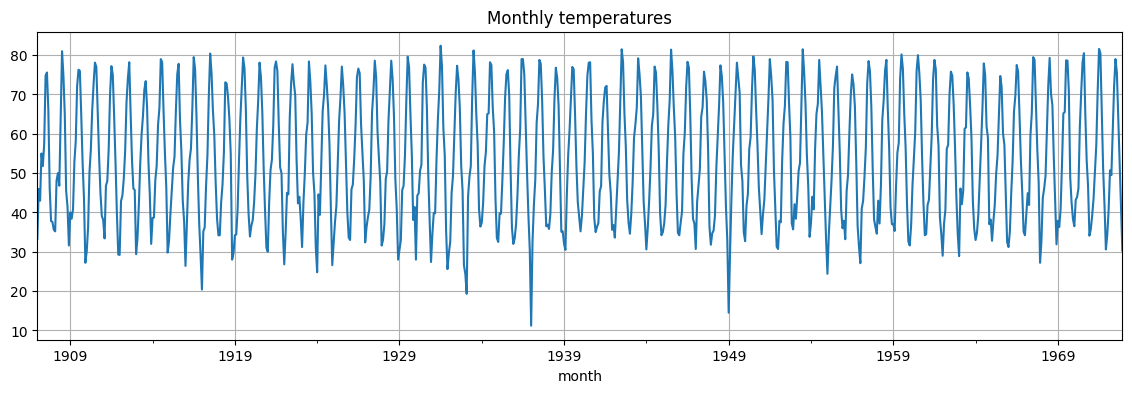

In [7]:
monthly_temp['temp'].plot(grid=True, figsize=(14, 4), title="Monthly temperatures");

- Вычислим среднегодовое значение и нанесем его поверх исходных данных.

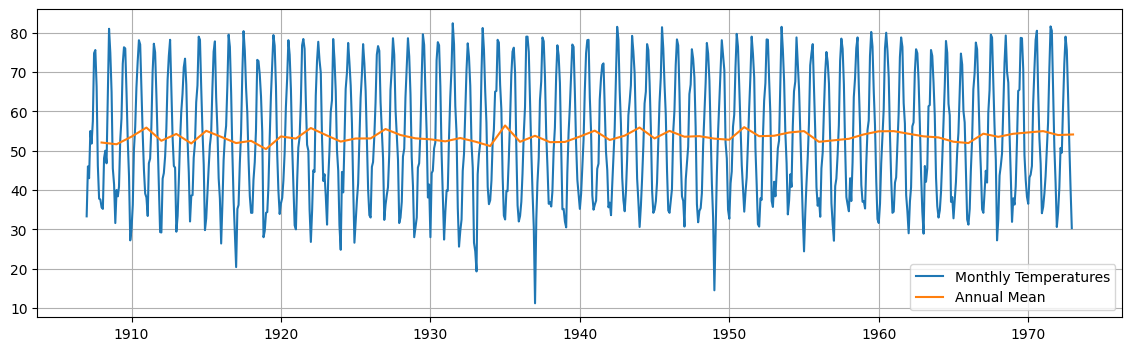

In [8]:
# Вычисляем среднегодовое значение
annual_temp = monthly_temp.resample('YE').mean()
annual_temp.index.name = 'year'

plt.figure(figsize=(14, 4))
plt.plot(monthly_temp, label="Monthly Temperatures")
plt.plot(annual_temp, label="Annual Mean")
plt.grid(); plt.legend();

- Это указывает на то, что среднее значение остается относительно постоянным с годами.
- Мы можем извлечь дополнительную информацию о скрытых трендах и сезонности, выполнив сезонное разложение.
- Для этого можно использовать как метод `seasonal_decompose`, так и метод  `STL`.

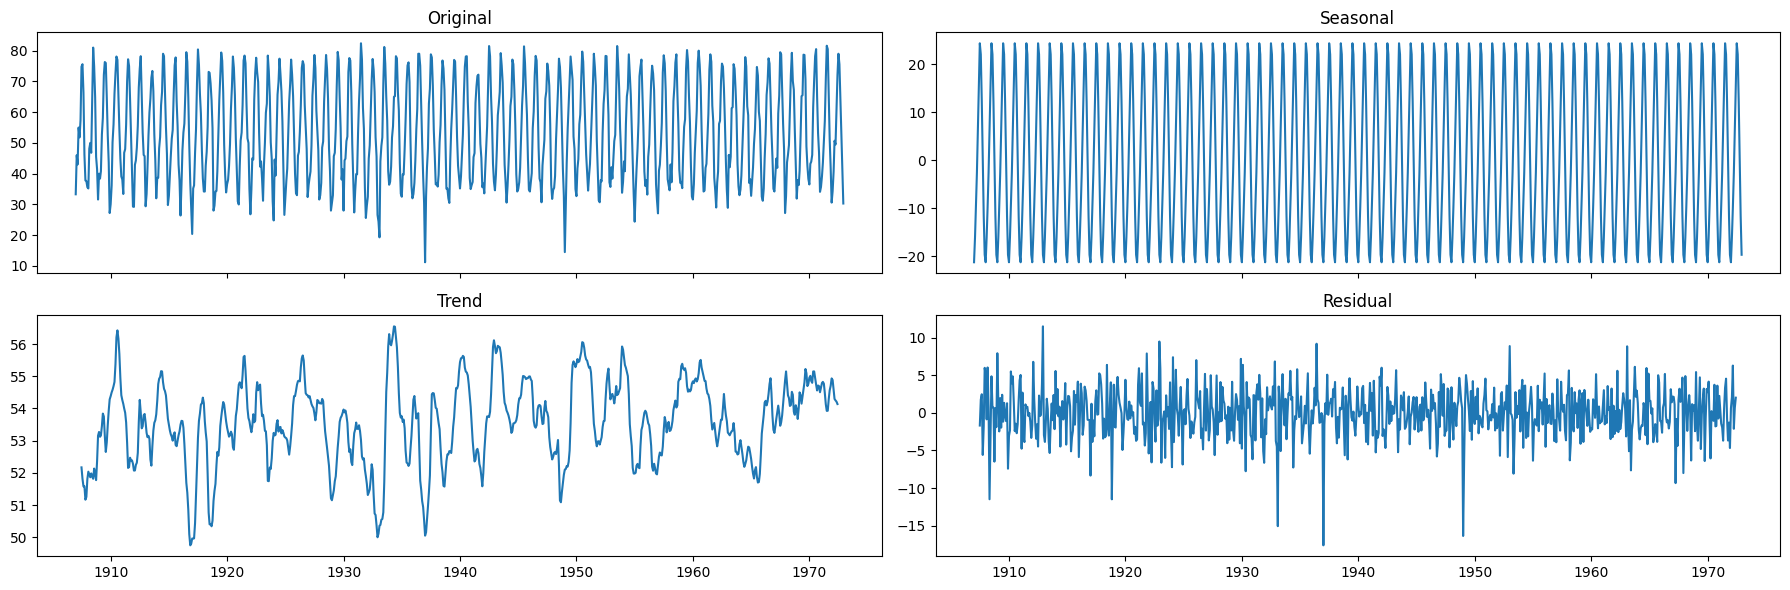

In [9]:
decomposition = seasonal_decompose(x=monthly_temp['temp'], model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(monthly_temp['temp'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

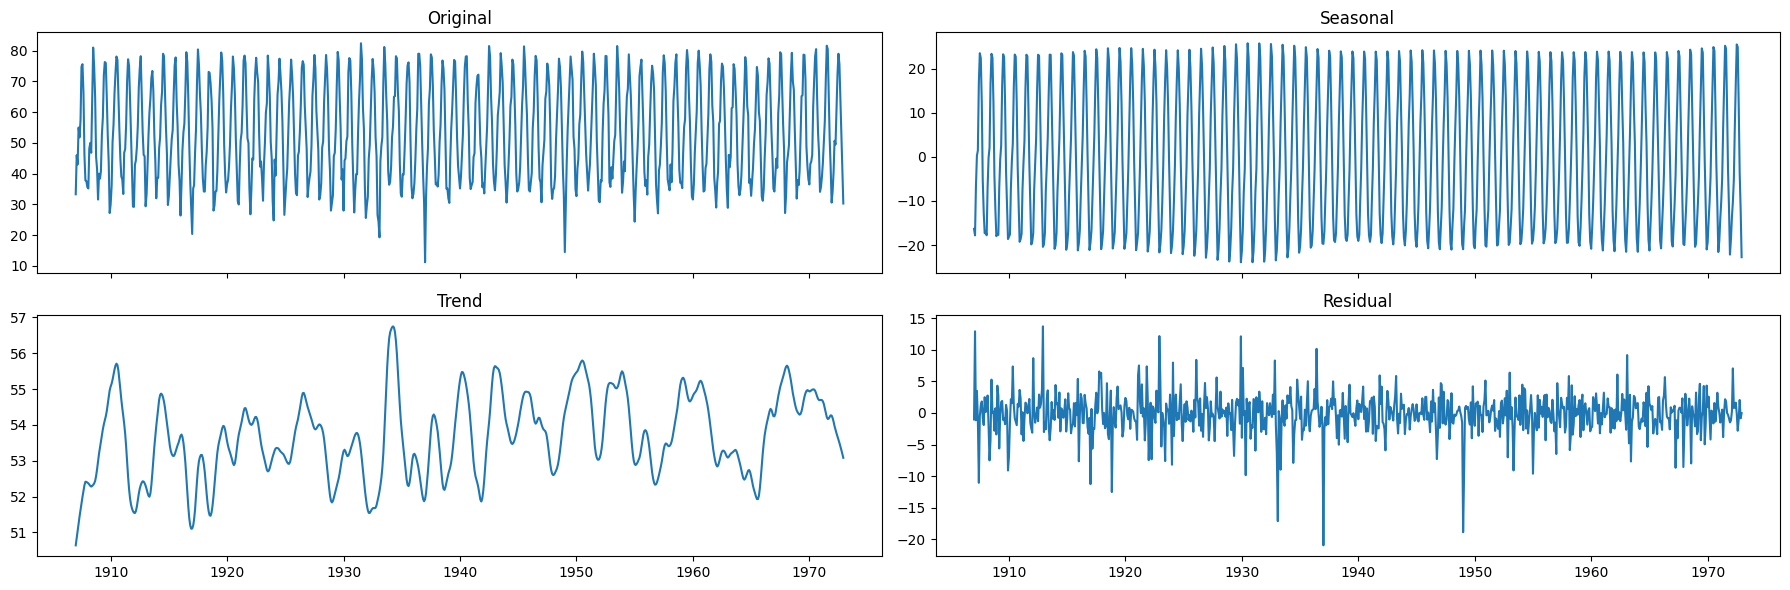

In [10]:
decomposition = STL(endog=monthly_temp['temp'], period=12, seasonal=13, robust=True).fit()
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(monthly_temp['temp'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

- Сезонность четко выражена.
- В данных не наблюдается сильного, изменяющегося во времени тренда.
    - Можно предположить, что тренд остается постоянным.
    
---

## Этапы моделирования ARMA

Существует три этапа построения модели ARMA:

1. Идентификация модели.
2. Обучение модели.
3. Оценка качества модели.

### Идентификация модели

- Идентификация модели заключается в нахождении порядков $p$ и $q$ для компонентов AR и MA.
- Перед выполнением идентификации модели необходимо:
    1. Определить, является ли временной ряд стационарным.
    2. Определить, есть ли во временном ряду сезонный компонент.

#### Определение стационарности

- Мы будем использовать инструменты, которые уже знаем (ADF test).
- Также можно проанализировать скользящее среднее и стандартное отклонение.

<br>
<div style="text-align: center; font-size: 30px; font-weight: bold;">⚠ ВНИМАНИЕ! ⚠</div>
<br>

- Прежде чем продолжить, давайте рассмотрим следующий результат:

In [11]:
sinusoid = np.sin(np.arange(200))
_, pvalue, _, _, _, _ = adfuller(sinusoid)
print(f'p-value: {pvalue}')

p-value: 0.0


- Периодические сигналы, по своей природе, имеют средние значения и дисперсии, которые повторяются в течение одного циклаe.
- Это означает, что их статистические свойства являются функциями времени в пределах каждого цикла.
- Например, среднее значение периодического сигнала за один цикл может быть постоянным.
- Однако, если рассматривать любой момент времени относительно цикла, мгновенное среднее значение сигнала может изменяться.
- Точно так же дисперсия может колебаться внутри цикла.

- Тест АДФ специально ищет единичный корень (подробнее об этом позже).
- Единичный корень указывает на то, что шоки в временном ряду имеют постоянное воздействие, вызывая дрейф в уровне ряда.
- Синусоидальная функция, напротив, по своей природе возвращается к среднему значению в пределах своих циклов.
- После пика синусоида возвращается к своему среднему значению, и любой "шок" в виде сдвига фазы или изменения амплитуды не изменяет ее колебательную природу.

- Важно отметить, что вывод теста АДФ о стационарности для синусоиды не означает, что синусоида является стационарной.
- Вывод теста касается отсутствия единичного корня.
- Это не означает, что среднее значение и дисперсия постоянны в пределах периодических колебаний.

---

In [12]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid();

ADF Statistic: -6.48
p-value: 0.000
Critical Values: ['1%: -3.44', '5%: -2.87', '10%: -2.57']



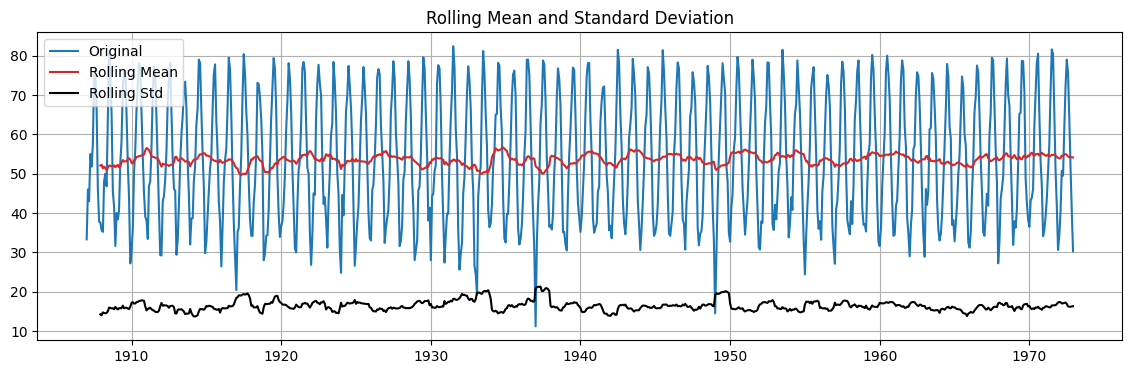

In [13]:
# Вычислим ADF для среднемесячных температур
adftest(monthly_temp.temp)

- p-значение указывает на то, что временной ряд является стационарным...
- ... даже если он явно имеет периодический компонент.
- Скользящее среднее и скользящее стандартное отклонение кажутся глобально постоянными по всему ряду...
- ... даже если они изменяются локально внутри периода.

#### Определение сезонности

Мы можем определить наличие сезонности с помощью следующих инструментов:
- График автокорреляции.
- График сезонных подсерий (график по месяцам).
- Преобразование Фурье.

In [14]:
# Вычислим ADF для среднегодовых значений
adftest(annual_temp.temp, plots=False) # no point in plotting the rolling mean/std here

ADF Statistic: -7.88
p-value: 0.000
Critical Values: ['1%: -3.54', '5%: -2.91', '10%: -2.59']



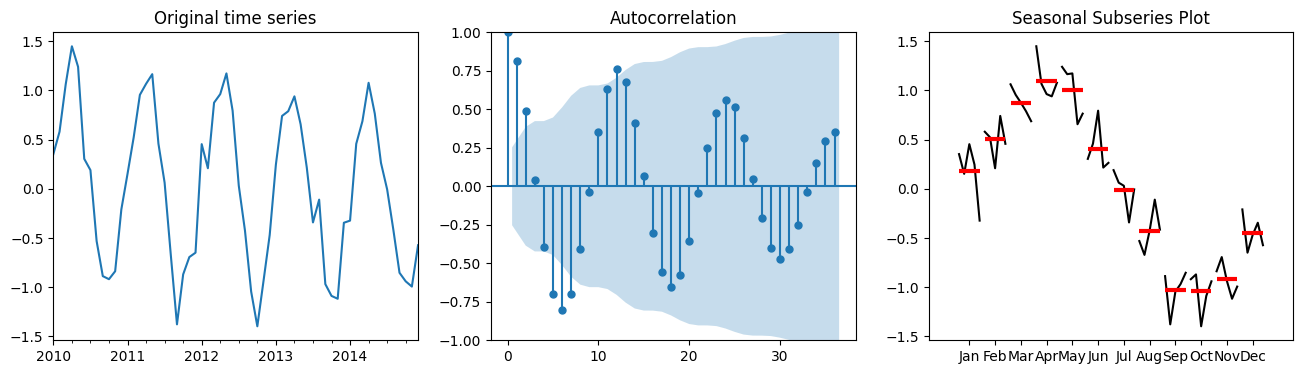

In [15]:
# Сгенерируем синтетический временной ряд
dates = pd.date_range(start='2010-01-01', periods=60, freq='M')  # Диапазон месяцев за 5 лет
seas = 12 # change this and see how the plots change
data = np.sin(np.arange(60)*2*np.pi/seas) + np.random.normal(loc=0, scale=0.2, size=60)  # Seasonal data with noise
series = pd.Series(data, index=dates)
fig, axes = plt.subplots(1,3,figsize=(16,4))
series.plot(ax=axes[0], title="Original time series")

# График авторкорреляции
plot_acf(series, lags=36, ax=axes[1]);

# Конвертируем Series в DataFrame и добавляем столбец month
df = series.to_frame(name='Value')
df['Month'] = df.index.month

# График сезонных подсерий
month_plot(df['Value'], ax=axes[2]); axes[2].set_title("Seasonal Subseries Plot");

- Давайте теперь рассмотрим реальные данные.

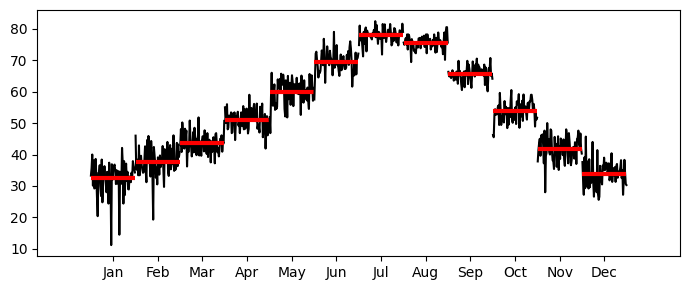

In [16]:
_, ax = plt.subplots(1,1, figsize=(7,3))
month_plot(monthly_temp, ax=ax)
plt.tight_layout();

- Обратите внимание `violinplot` может предоставить информацию, очень похожую на график по месяцам `month_plot`.

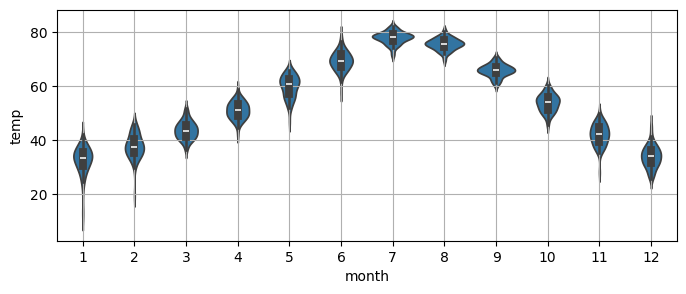

In [17]:
_, ax = plt.subplots(1,1, figsize=(8,3))
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp, ax=ax) # notice the indexing on the x by month
plt.grid();

- Наконец, чтобы получить числовое значение основной периодичности, мы можем использовать преобразование Фурье (подробнее об этом позже).
- Здесь мы воспользуемся функцией, которую мы определили на первом занятии.

In [18]:
def fft_analysis(signal):

    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept
    detrended = signal - trend

    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")

    return dominant_period, positive_frequencies, magnitudes

In [19]:
dominant_period, _, _ = fft_analysis(monthly_temp['temp'].values)
print(f"Dominant period: {np.round(dominant_period)}")

Dominant Frequency: 0.083
Dominant Period: 12.00 time units
Dominant period: 12.0


#### Устраняем основную сезонность

- В этом случае ясно, что основная сезонность составляет $L=12$.
- Мы можем удалить сезонность с помощью сезонного дифференцирования.

In [20]:
monthly_temp['Seasonally_Differenced'] = monthly_temp['temp'].diff(12)

In [21]:
# Drop nan
monthly_temp_clean = monthly_temp.dropna()
monthly_temp_clean

,temp,Seasonally_Differenced
month,,
1908-01-01,35.6,2.3
1908-02-01,35.2,-10.8
1908-03-01,48.1,5.1
1908-04-01,50.0,-5.0
1908-05-01,46.8,-5.0
...,...,...
1972-08-01,75.6,-4.9
1972-09-01,64.1,-1.7
1972-10-01,51.7,0.6


**⚙ Попробуйте сами**

- Попробуйте повторить предыдущие графики для данных после сезонного дифференцирования!

#### Идентификация AR и MA порядков

Как мы узнали на прошлом занятии, мы будем определять порядок AR (p) и порядок MA (q) с помощью:

- Графика функции автокорреляции (ACF).
- Графика функции частичной автокорреляции (PACF).

**AR($p$)**

- Порядок модели AR определяется следующим образом:
    - Наносим на график PACF 95%-й доверительный интервал (что автоматически делает библиотека statsmodels).
    - Выбираем лаг $p$, такой что частичная автокорреляция становится незначимой для лагов $p+1$ и более.

- Если процесс зависит от предыдущих значений самого себя, то это процесс AR.
- Если он зависит от предыдущих ошибок, то это процесс MA.
- Процесс AR распространяет шоки бесконечно.
- Процесс AR будут показывать экспоненциальное затухание в ACF и обрезание в PACF.

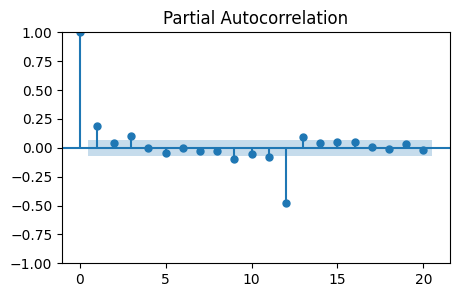

In [22]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax);

- Похоже, что PACF становится нулевым на лаге 2.
- Однако существует ненулевая частичная автокорреляция на лаге 3.
- Оптимальное значение может быть $p=1$, $p=2$, или $p=3$.
- Обратите внимание, что на более высоких лагах, особенно на 12, есть высокие частичные автокорреляции.
    - Это эффект сезонности и сезонного дифференцирования.
    - Это не должно учитываться при выборе $p$.

**MA($q$)**

- Порядок модели MA определяется следующим образом:
    - Наносим на график ACF 95%-й доверительный интервал (что автоматически делает библиотека statsmodels).
    - Выбираем лаг $q$, такой что ACF становится статистически равным нулю для лагов $q+1$ и более.

- Модели MA не распространяют шоки бесконечно; они исчезают после $q$ лагов.
- Процессы MA будут показывать экспоненциальное затухание в PACF и обрезание в ACF.

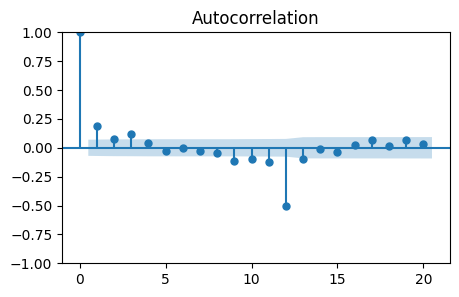

In [23]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax);

- Также в этом случае есть ненулевые автокорреляции на лагах 1 и 3.
- Таким образом, значения, которые стоит попробовать, это $q=1$, $q=2$ или $q=3$.

### Обучение модели

- После того как определены порядки $p$ и $q$, необходимо оценить параметры $\phi_1, \dots, \phi_p$ для части AR и параметры $\theta_1, \dots, \theta_q$ для части MA.
-  Поиск значений параметров модели ARMA - это сложная, нелинейная задача.
- Обычные методы включают нелинейные наименьшие квадраты и оценку максимального правдоподобия (MLE).
- Многие современные программные средства могут определить значения параметров модели ARMA для нас.

- Разделим данные на две части:
    - обучающий набор, который будет использован для поиска значений параметров модели.
    - тестовый набор, который будет использован позже для оценки прогностической способности модели на новых данных.

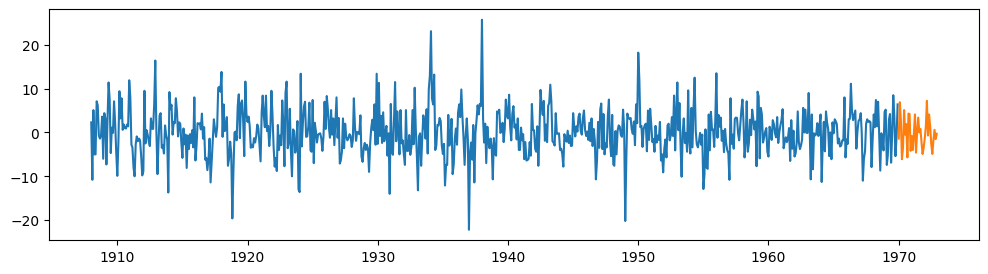

In [24]:
train = monthly_temp_clean['Seasonally_Differenced'][:-36]
test = monthly_temp_clean['Seasonally_Differenced'][-36:]

plt.figure(figsize=(12,3))
plt.plot(train)
plt.plot(test);

In [25]:
model = ARIMA(train, order=(3, 0, 3))  # ARIMA with d=0 is equivalent to ARMA
fit_model = model.fit()

print(fit_model.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Seasonally_Differenced   No. Observations:                  744
Model:                     ARIMA(3, 0, 3)   Log Likelihood               -2248.068
Date:                    Mon, 26 May 2025   AIC                           4512.135
Time:                            23:27:07   BIC                           4549.032
Sample:                        01-01-1908   HQIC                          4526.358
                             - 12-01-1969                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0643      0.244      0.263      0.792      -0.415       0.543
ar.L1         -0.0939      0.143     -0.656      0.512      -0.374       0.187
ar.L2         -0.828

### Валидация модели ARMA

- Как узнать, хороша ли ваша модель ARMA??
- Мы можем проверить остатки, то есть то, что модель не смогла описать.
- Остатки должны приближаться к нормальному распределению (или белому шуму).
- Если это не так, возможно, нужно выбрать лучшую модель.

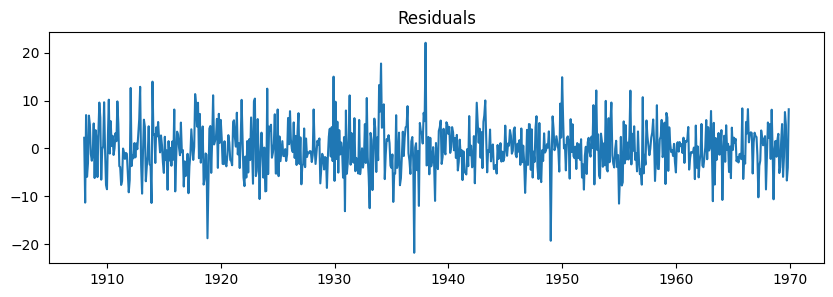

In [26]:
residuals = fit_model.resid

plt.figure(figsize=(10,3))
plt.plot(residuals)
plt.title("Residuals");

**🤔 Как проверить, выглядят ли остатки как шум?**

- Мы будем использовать как визуальную проверку, так и статистические тесты.
- Визуальная проверка:
    - График ACF.
    - Гистограмма.
    - QQ-график.
- Статистические тесты:
    - Нормальность.
    - Автокорреляция.
    - Гетероскедастичность.

#### Визуальная проверка

**График ACF**

- Проверяет наличие автокорреляции в остатках.
- Белый шум не должен показывать значительную автокорреляцию на всех лагах.

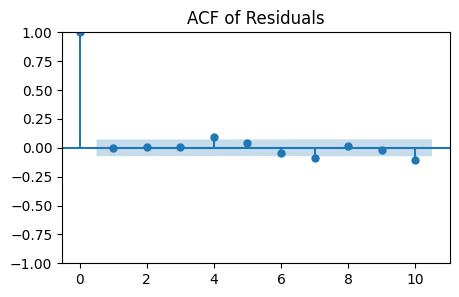

In [27]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(residuals, lags=10, ax=ax)
plt.title('ACF of Residuals')
plt.show()

**Гистограмма и QQ-график**
- Оценка нормальности остатков.
- Белый шум в идеале должен следовать нормальному распределению.

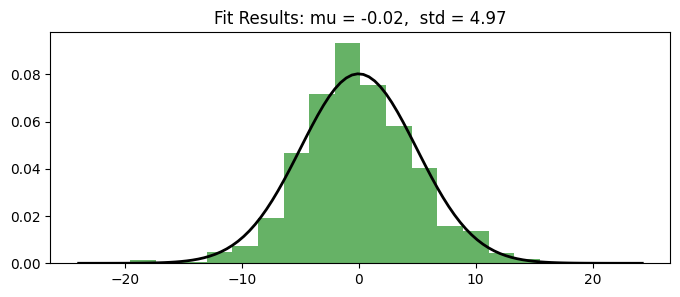

In [28]:
# Histogram
plt.figure(figsize=(8,3))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='g')
# Add the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Results: mu = %.2f,  std = %.2f" % (np.mean(residuals), np.std(residuals))
plt.title(title)
plt.show()

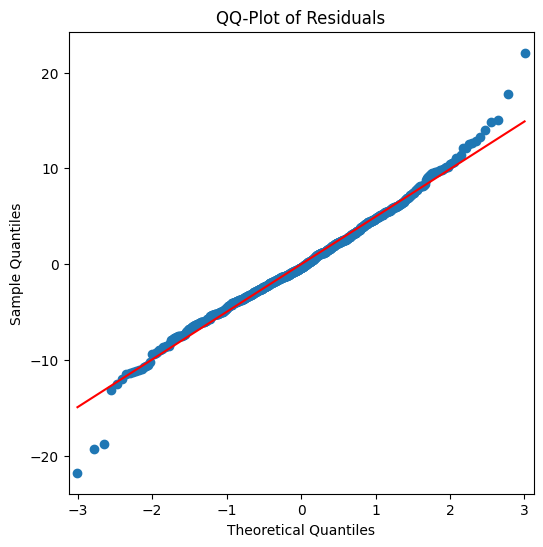

In [29]:
# QQ-Plot
_, ax = plt.subplots(1, 1, figsize=(6, 6))
qqplot(residuals, line='s', ax=ax)
plt.title('QQ-Plot of Residuals')
plt.show()

- Графики удобно суммируются в функции plot_diagnostics(), которую можно вызвать для обученной модели.

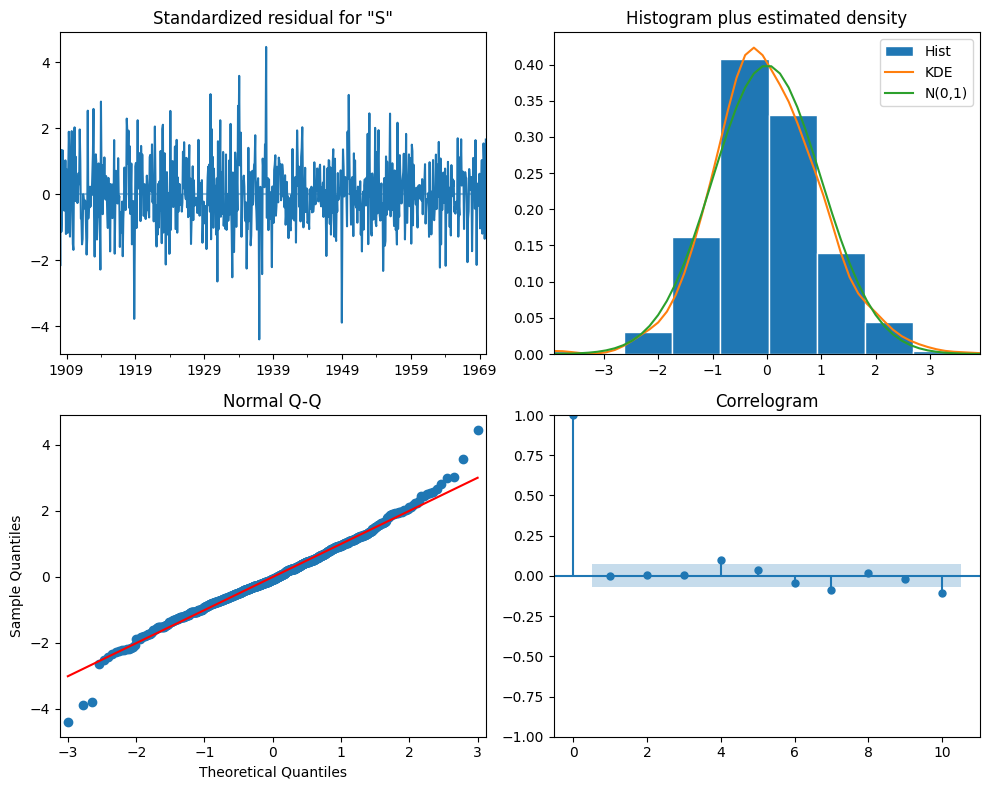

In [30]:
fit_model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout();

#### Статистические тесты

**Нормальность: тесты Жарке-Бера и Шапиро-Уилка**

> $H_0$: остатки распределены нормально.

In [31]:
norm_val, norm_p, skew, kurtosis = fit_model.test_normality('jarquebera')[0]
print('Normality (Jarque-Bera) p-value:{:.3f}'.format(norm_p))

Normality (Jarque-Bera) p-value:0.000


In [32]:
shapiro_test = stats.shapiro(residuals)
print(f'Normality (Shapiro-Wilk) p-value: {shapiro_test.pvalue:.3f}')

Normality (Shapiro-Wilk) p-value: 0.000


- Малые p-значения позволяют отклонить $H_0$.
- Вывод: остатки **не** распределены нормально.

**📝 Примечание**
- Для справки давайте посмотрим, что эти тесты говорят о данных, которые на самом деле распределены нормально.
- Попробуйте выполнить ячейку ниже несколько раз и посмотрите, как результаты изменяются каждый раз.
- Эти тесты начинают быть надежными только при больших размерах выборки ($N>5000$).

In [33]:
# generate random normal data
normal_data = np.random.normal(loc=0, scale=1, size=1000)

jb_test = stats.jarque_bera(normal_data)
print(f'Normality (Jarque-Bera) p-value: {jb_test.pvalue:.3f}')

shapiro_test = stats.shapiro(normal_data)
print(f'Normality (Shapiro-Wilk) p-value: {shapiro_test.pvalue:.3f}')

Normality (Jarque-Bera) p-value: 0.811
Normality (Shapiro-Wilk) p-value: 0.938


**Автокорреляция: тест Льюнга-Бокса**

> $H_0$: остатки независимы (отсутствие автокорреляции).

- Для каждого лага есть свое $p$-значение.
- Здесь мы просто берем среднее значение, но можно также обратить внимание на наибольшее значение $p$-значения (pval[-1]).
- Также не всегда очевидно, сколько лагов следует использовать в теcте...

In [34]:
statistic, pval = fit_model.test_serial_correlation(method='ljungbox', lags=10)[0]
print(f'Ljung-Box p-value: {pval.mean():.3f}')
print(f'p-value of max lag: {pval[-1]:.3f}')

Ljung-Box p-value: 0.359
p-value of max lag: 0.007


**Автокорреляция: тест Дербина-Уотсона**

- Тестирует автокорреляцию в остатках.
- Мы хотим, чтобы значение находилось в пределах от 1 до 3.
- Идеальное значение — 2 (отсутствие серийной корреляции).

In [35]:
durbin_watson = ss.stats.stattools.durbin_watson(fit_model.filter_results.standardized_forecasts_error[0, fit_model.loglikelihood_burn:])
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Durbin-Watson: d=2.00


**Тест на гетероскедастичность**

- Тестирует изменение дисперсии между остатками.
> $H_0$: отсутствие гетероскедастичности.
- $H_0$ указывает на разные вещи в зависимости от альтернативы $H_A$:
    - $H_A$: Увеличение, $H_0$: дисперсия не увеличивается по всему ряду.
    - $H_A$: Уменьшение, $H_0$: дисперсия не уменьшается по всему ряду.
    - $H_A$: Двусторонний (по умолчанию), $H_0$: дисперсия не увеличивается и не уменьшается по всему ряду.

In [36]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='increasing')[0]
print(f'H_a: Increasing - pvalue:{pval:.3f}')

H_a: Increasing - pvalue:0.981


In [37]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='decreasing')[0]
print(f'H_a: Decreasing - pvalue:{pval:.3f}')

H_a: Decreasing - pvalue:0.019


In [38]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='two-sided')[0]
print(f'H_a: Two-sided - pvalue:{pval:.3f}')

H_a: Two-sided - pvalue:0.039


**Резюме наших тестов**

Независимость:
- &#x2705; График ACF.
- &#x2705; Тест Льюнга-Бокса.
- &#x2705; Тест Дербина-Уотсона.

Normality:
- &#x2705; Гистограмма/Плотность распределения.
- 🤔 QQ-график
- &#x274C; Тест Жарке-Бера (надежен для больших выборок).
- &#x274C;  Тест Шапиро-Уилка (надежен для больших выборок).

Гетероскедастичность
- &#x274C; Тест на гетероскедастичность.

- Тесты дают несколько неопределенные результаты.
- Нет сильных доказательств того, что модель является либо очень хорошей, либо очень плохой.
- Вероятно, будет разумно попробовать другие модели, например, ARMA(2,0,2), и повторить тесты.

### Прогнозы модели ARMA

- После обучения модели, мы можем использовать её для прогнозирования тестовых данных.
- Прогнозы представляют собой распределение.
- Другими словами, ARMA выполняет *вероятностное прогнозирование*.
- Среднее (или мода) этого распределения соответствует наиболее вероятному значению и является нашим прогнозом.
- Остальная часть распределения может быть использована для вычисления доверительных интервалов.

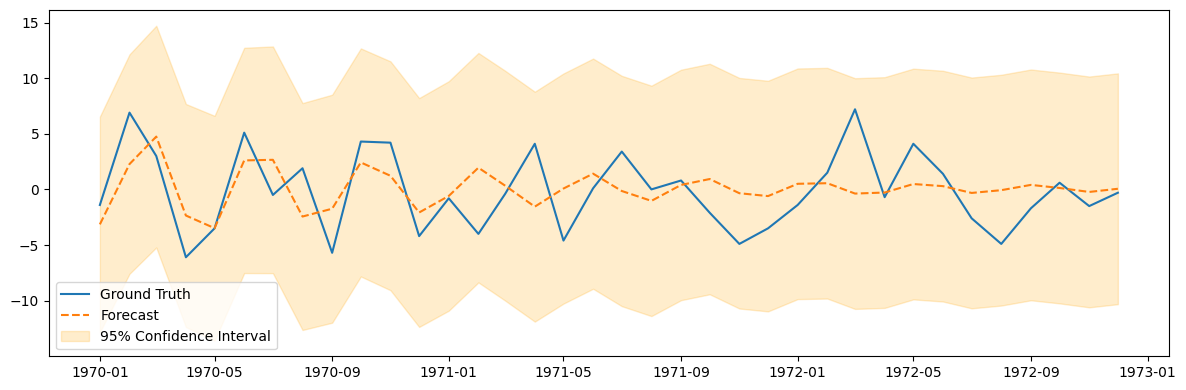

In [39]:
pred_summary = fit_model.get_prediction(test.index[0], test.index[-1]).summary_frame()

plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label='Ground Truth')
plt.plot(test.index, pred_summary['mean'], label='Forecast', linestyle='--')
plt.fill_between(test.index, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'],
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.tight_layout();

---

## Модель ARIMA 

- ARIMA расшифровывается как Авторегрессионная Интегрированная Модель Скользящего Среднего.
- Модель ARIMA включает три компонента:
    - Модель AR (авторегрессия).
    - Интегрированная компонента (подробнее об этом скоро).
    - Модель MA (скользящее среднее).

- Модель ARIMA обозначается как ARIMA($p, d, q$).
    - $p$ порядок модели AR.
    - $d$ количество дифференцирований данных.
    - $q$ порядок модели MA.
    - $p$, $d$, и $q$ это неотрицательные целые числа.

- Как мы видели ранее, дифференцирование нестационарных временных рядов один или несколько раз может сделать их стационарными.
- Это роль интегрированной (I) компоненты модели ARIMA.
- $d$ — количество дифференцирований, которые нужно выполнить на данных с лагом 1.
    - $d=0$: без дифференцирования.
    - $d=1$: дифференцировать один раз.
    - $d=2$: дифференцировать дважды.

- Модель ARMA подходит для стационарных временных рядов, где среднее и дисперсия не изменяются со временем.
- Модель ARIMA эффективно моделирует нестационарные временные ряды, выполняя их дифференцирование.
- Фактически, ARIMA делает временной ряд стационарным, прежде чем применять модель ARMA.
- Давайте разберем это на примере.

In [40]:
# Generate synthetic stationary data with an ARMA(1,1) process
n = 250
ar_coeff = np.array([1, -0.7]) # The first value refers to lag 0 and is always 1. In addition, AR coeff are negated.
ma_coeff = np.array([1, 0.7])  # The first value refers to lag 0 and is always 1
arma_data = ss.tsa.arima_process.ArmaProcess(ar_coeff, ma_coeff).generate_sample(nsample=n, burnin=1000)

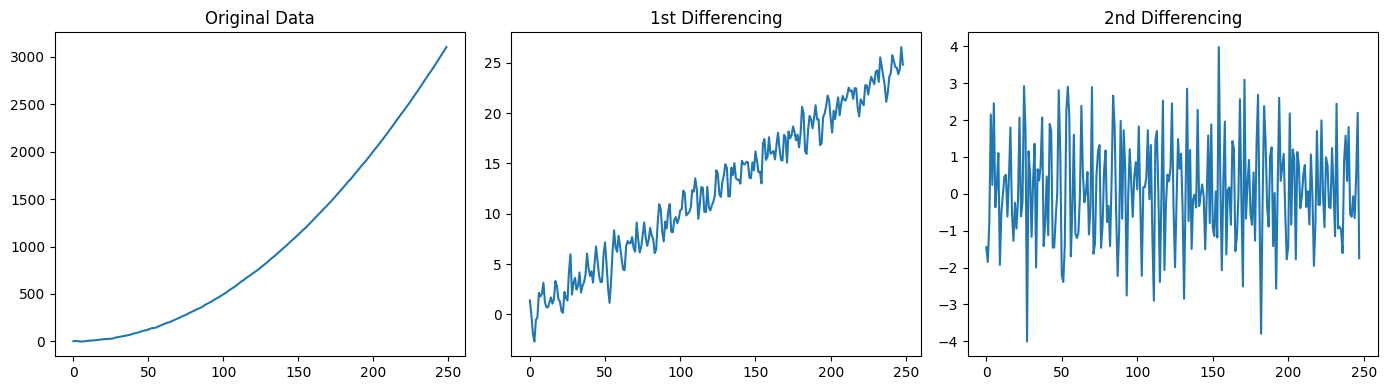

In [41]:
# Generate a synthetic non-stationary data (needs to be differenced twice to be stationary)
t = np.arange(n)
non_stationary_data = 0.05 * t**2 + arma_data  # Quadratic trend

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].plot(non_stationary_data)
axes[0].set_title('Original Data')
axes[1].plot(diff(non_stationary_data, k_diff=1))
axes[1].set_title('1st Differencing')
axes[2].plot(diff(non_stationary_data, k_diff=2))
axes[2].set_title('2nd Differencing')
plt.tight_layout();

220


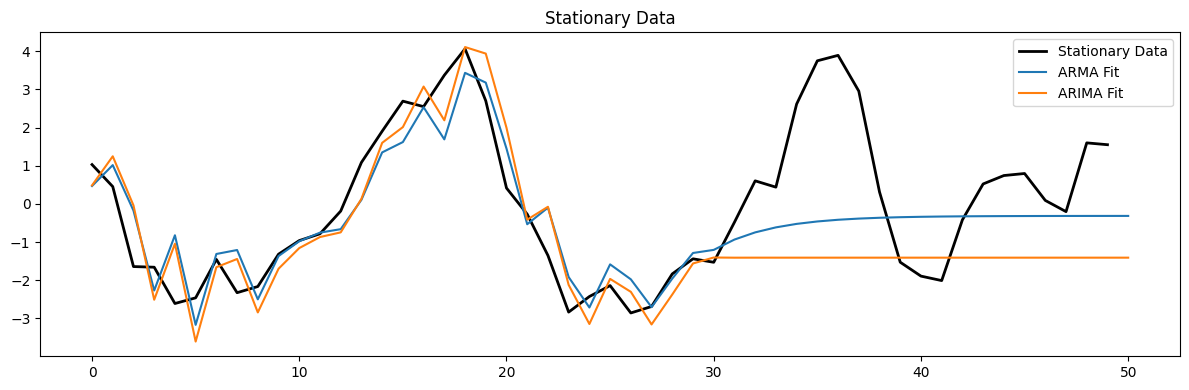

In [42]:
# Fit models to stationary data
arma_model = ARIMA(arma_data[:-20], order=(1, 0, 1)).fit()
arima_model = ARIMA(arma_data[:-20], order=(1, 1, 1)).fit()

plt.figure(figsize=(12, 4))
plt.plot(arma_data[-50:], 'k', label='Stationary Data', linewidth=2)
plt.plot(arma_model.predict(200,250), label='ARMA Fit')
plt.plot(arima_model.predict(200, 250), label='ARIMA Fit')
plt.legend()
plt.title('Stationary Data')
plt.tight_layout();

print(len(arma_model.predict(10)))

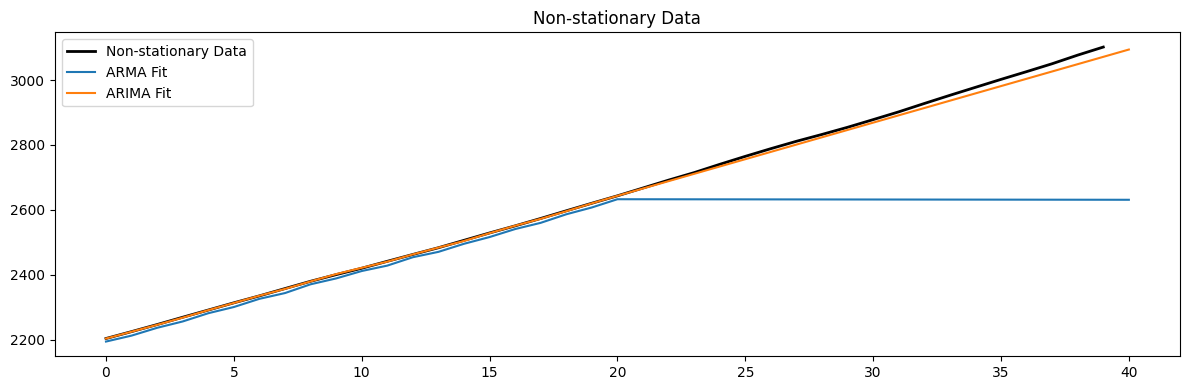

In [43]:
# Fit models to non-stationary data
arma_model = ARIMA(non_stationary_data[:-20], order=(1, 0, 1)).fit()
arima_model = ARIMA(non_stationary_data[:-20], order=(1, 2, 1)).fit()

plt.figure(figsize=(12, 4))
plt.plot(non_stationary_data[-40:], 'k', label='Non-stationary Data', linewidth=2)
plt.plot(arma_model.predict(210,250), label='ARMA Fit')
plt.plot(arima_model.predict(210,250), label='ARIMA Fit')
plt.legend()
plt.title('Non-stationary Data')
plt.tight_layout();

---

## Модель SARIMA

- Чтобы применить ARMA и ARIMA, мы должны удалить сезонную компоненту.
- После вычисления прогнозов необходимо вернуть сезонную компоненту обратно.
- Было бы удобно работать напрямую с данными, содержащими сезонность.

- SARIMA — это расширение модели ARIMA, которое включает сезонные компоненты.
- Модель обозначается как SARIMA $(p, d, q) \times (P, D, Q, s)$:
  - Обычные компоненты ARIMA $(p, d, q)$.
  - Сезонные компоненты $(P, D, Q, s)$, где:
    - $P$: порядок сезонной авторегрессии.
    - $D$: порядок сезонного дифференцирования.
    - $Q$: порядок сезонного скользящего среднего.
    - $s$: количество временных шагов в одном сезонном периоде.

**Как выбрать значения $s$, $P$, $D$, $Q$?**
- $s$:
    - Это основная сезонность в данных.
    - Мы уже знаем, как её найти.
- $P$ и $Q$:
    - На графиках PACF/ACF должен быть виден пик на $s$-м лаге (и, возможно, на его кратных)..
    - Например, если $s = 12$, пики могут быть на лагах вида $(s*n)$.
    - Выберите лаги с наибольшими пиками как кандидатов для $P$ или $Q$.
- $D$:
    - Это количество сезонных дифференцирований, необходимых для того, чтобы временной ряд стал стационарным.
    - Обычно определяется методом проб и ошибок или путём анализа сезонно-дифференцированных данных.

**💡 Правило для выбора параметров**
- Прежде чем выбирать $P$ и $Q$, убедитесь, что ряд стал сезонно стационарным, применив сезонное дифференцирование при необходимости ($D$).
- Посмотрите на график ACF, чтобы определить порядок сезонного скользящего среднего $Q$.
  - Ищите значительные автокорреляции на сезонных лагах (кратных $s$).
  - Если на графике ACF наблюдается резкое обрезание на сезонных лагах, это может указывать на порядок сезонной MA компоненты ($Q$).
  
- Посмотрите на график PACF, чтобы определить порядок сезонной авторегрессии $P$.
  - Ищите значительные пики в точках, кратных сезонности $s$.
  - Резкое обрезание на графике PACF на сезонном лаге может свидетельствовать о порядке сезонных AR компонент ($P$).

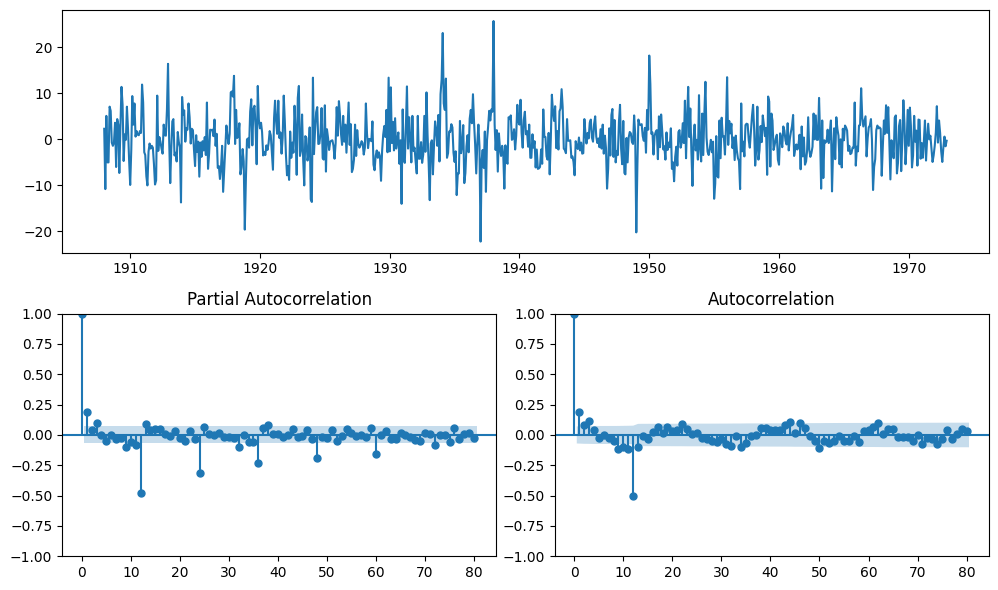

In [44]:
diff_ts = monthly_temp['temp'].diff(periods=12).dropna()

fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(diff_ts)
ax2 = plt.subplot2grid((2, 2), (1, 0))
plot_pacf(diff_ts, lags=80, ax=ax2)
ax3 = plt.subplot2grid((2, 2), (1, 1))
plot_acf(diff_ts, lags=80, ax=ax3)
plt.tight_layout();

In [45]:
# fit SARIMA monthly based on helper plots
sar = ss.tsa.statespace.sarimax.SARIMAX(monthly_temp[:750].temp,
                                order=(2,1,2),
                                seasonal_order=(0,1,1,12),
                                trend='c').fit(disp=False)
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  750
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2026.037
Date:                              Mon, 26 May 2025   AIC                           4066.073
Time:                                      23:27:13   BIC                           4098.291
Sample:                                  01-01-1907   HQIC                          4078.498
                                       - 06-01-1969                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.775e-05      0.000     -0.379      0.705      -0.000       0.000
ar.L1         -0.7664      0.247     -3.108      0.002      -1.250      -0.283
ar.L2          0.1792      0.051      3.534      0.000       0.080       0.279
ma.L1         -0.0504      0.259     -0.195      0.846      -0.558       0.457
ma.L2         -0.9475      0.249     -3.813      0.000      -1.435      -0.460
ma.S.L12      -0.9825      0.041    -23.952      0.000      -1.063      -0.902
sigma2        13.3551      1.062     12.572      0.000      11.273      15.437
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               204.22
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.55
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

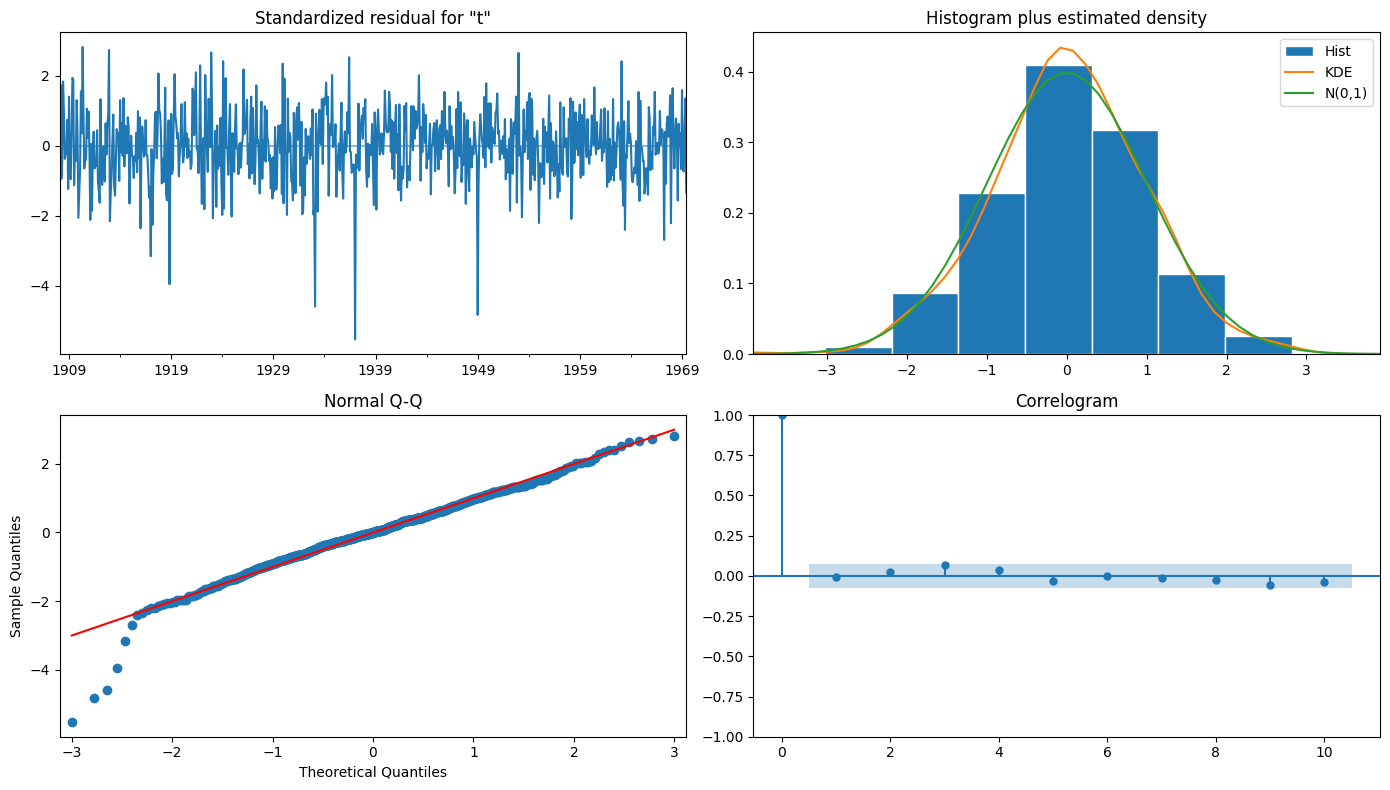

In [46]:
sar.plot_diagnostics(figsize=(14, 8))
plt.tight_layout();

MSE: 9.23


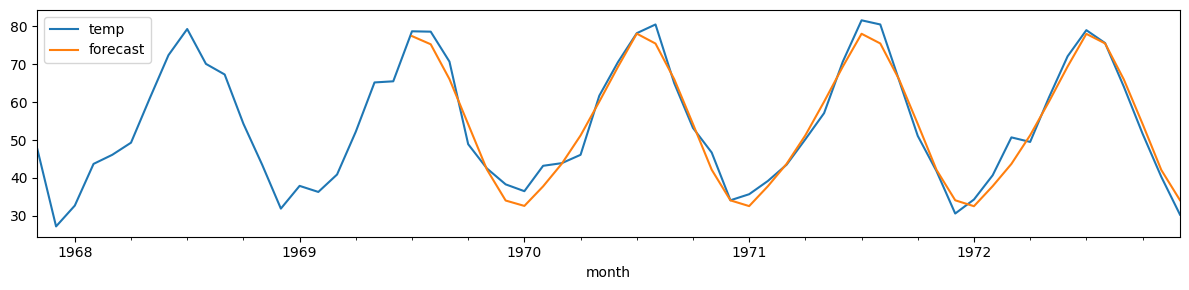

In [47]:
monthly_temp['forecast'] = sar.predict(start = 750, end= 792, dynamic=False)
monthly_temp[730:][['temp', 'forecast']].plot(figsize=(12, 3))
plt.tight_layout();
print(f"MSE: {mse(monthly_temp['temp'][-42:],monthly_temp['forecast'][-42:]):.2f}")

## Модель AutoARIMA

- На этом этапе должно быть понятно, что идентификация оптимальной модели SARIMA — это сложный процесс.
- Это требует тщательного анализа, проб и ошибок, а также определённого опыта.
- Следующая шпаргалка резюмирует некоторые основные правила для выбора модели.

**💡 Шпаргалка: выбор модели**

<center>
    
|Форма ACF|Предполагаемая модель|
|---|:---|
|Экспоненциальное убывание до нуля|Модель AR. Используйте PACF для определения порядка модели AR.|
|Чередующиеся положительные и отрицательные значения, убывающие до нуля|Модель AR. Используйте PACF для определения порядка.|
|Один или несколько пиков, остальные близки к нулю|Модель MA, порядок определяется тем, где график становится нулевым.|
|Убывание, начинающееся после нескольких лагов|Смешанная модель AR и MA (ARMA).|
|Все значения равны нулю или близки к нулю|Данные в основном случайные.|
|Высокие значения на фиксированных интервалах|Включите сезонную AR компоненту.|
|Нет убывания до нуля|Ряд не стационарен.|
    
</center>

- Альтернативой ручному выбору модели является использование автоматизированных процедур.
- Здесь на помощь приходит AutoARIMA.
- AutoARIMA требует указания максимального диапазона значений для проб.
- После этого он пытается найти наилучшую конфигурацию среди возможных.
- Полный список и описание доступных опций можно найти [здесь](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html).

In [48]:
# Split the data into train and test sets
train, test = monthly_temp[:750].temp, monthly_temp[750:].temp

# Use auto_arima to find the best ARIMA model
model = pm.auto_arima(train,
                      start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=2, max_q=2, # Maximum p and q
                      m=12,             # Seasonality
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2, # Maximum p and q
                      seasonal=True,    # Seasonal ARIMA
                      d=None,           # Let model determine 'd'
                      D=1,              # Seasonal difference
                      trace=True,       # Print status on the fits
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)    # Stepwise search to find the best model

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4558.569, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4318.918, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4556.588, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4531.290, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4230.055, Time=1.07 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4256.241, Time=0.76 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4230.500, Time=1.42 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=4228.386, Time=1.53 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4317.592, Time=0.57 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=4

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  750
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood               -2108.234
Date:                             Mon, 26 May 2025   AIC                           4226.467
Time:                                     23:27:45   BIC                           4249.487
Sample:                                 01-01-1907   HQIC                          4235.344
                                      - 06-01-1969                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5814      0.144      4.027      0.000       0.298       0.864
ma.L1         -0.4101      

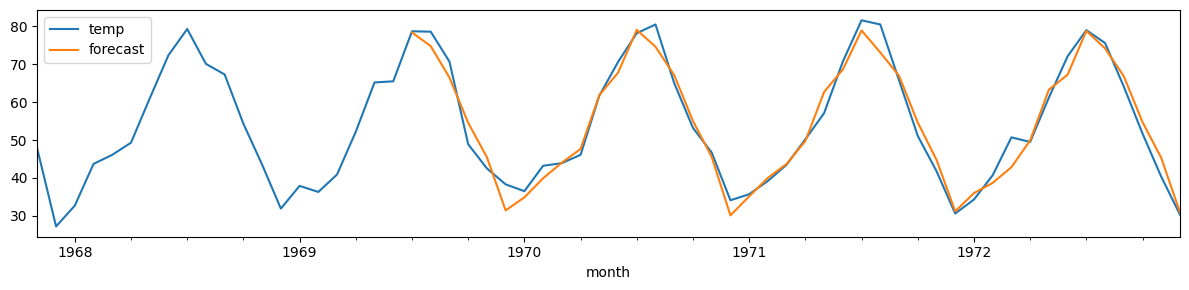

In [49]:
# Summarize the model
print(model.summary())

# Forecast future values
monthly_temp['forecast'] = model.predict(n_periods=len(test))
monthly_temp[730:][['temp', 'forecast']].plot(figsize=(12, 3))
plt.tight_layout();
print(f"MSE: {mse(monthly_temp['temp'][-42:],monthly_temp['forecast'][-42:]):.2f}")

### AutoARIMA или не AutoARIMA?

Хотя это очень удобно, как и все автоматизированные процедуры, auto_arima имеет свои недостатки.

1. Использование `auto_arima` может быть *вычислительно затратным*, особенно для больших наборов данных и при исследовании широкого диапазона моделей.

2. Автоматический выбор модели лишён тех качественных инсайтов, которые может внести человек в процесс моделирования.
   - К ним относятся понимание бизнес-циклов, внешних факторов или аномалий в данных.

3. Настройки по умолчанию в `auto_arima` могут быть не оптимальными для всех временных рядов.
   - Диапазон значений для исследования должен быть правильно настроен каждый раз.
   - Это может стать почти таким же сложным, как и ручной выбор модели.

4. `auto_arima` требует достаточно длинного временного ряда, чтобы точно выявить паттерны и сезонность.

5. Выбор лучшей модели обычно основывается на *статистических критериях*, таких как AIC или BIC.
   - Однако они не всегда совпадают с практическими метриками качества, такими как MSE.

## Подбор параметров по сетке

- Выбор лучшей модели ARIMA — это не только наука, но и искусство, требующее итераций и доработок.
- Обычным подходом является выбор набора кандидатов для параметров $(p,d,q)\times (P,D,Q,s)$ и подгонка модели для каждой возможной комбинации.

- Для каждой обученной модели:
    - Анализируйте остатки с помощью визуальных техник и статистических тестов, обсуждавшихся ранее.
    - Оцените качество предсказания. 🤔 Как?
    - Оцените сложность модели. 🤔 Как?

### Оценка качества предсказания

Используйте **MSE (среднеквадратическую ошибку)** и/или **MAPE (среднюю абсолютную процентную ошибку)** для оценки производительности модели.

**Среднеквадратическая ошибка (MSE)**

- MSE — это среднее значение квадратов разностей между наблюдаемыми значениями и предсказаниями..
- $MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \hat{Y}_i)^2$, где $Y_i$ это фактическое наблюдение, а $\hat{Y}_i$ предсказанное значение.
- При выборе модели SARIMA модель с меньшим значением MSE предпочтительнее, так как она лучше описывает данные.

**Средняя абсолютная процентная ошибка (MAPE)**

- MAPE это среднее значение абсолютных процентных ошибок предсказаний.
- $MAPE = \frac{100\%}{n}\sum_{i=1}^{n}\left|\frac{Y_i - \hat{Y}_i}{Y_i}\right|$, где $Y_i$ то фактическое наблюдение, а  $\hat{Y}_i$ предсказанное значение.
- MAPE выражает ошибки в процентах, что позволяет легко понять величину ошибок предсказания.
- Если вы сравниваете модели, которые прогнозируют разные величины (например, доллары и количество проданных единиц), процентная ошибка позволяет сделать более прямое сравнение.
- Также, если вас больше интересует относительный размер ошибок, а не их абсолютный размер, MAPE будет более актуальной.
- В конце концов, MAPE полезна, когда величина данных значительно варьируется.

### Сложность модели

Используйте **AIC** или **BIC** чтобы оценить сложность модели.

**Akaike Information Criterion (AIC)**

- AIC — это мера относительного качества статистических моделей для данного набора данных.
- Он учитывает компромисс между точностью модели (насколько хорошо модель описывает данные) и сложностью модели (сколько параметров в модели).


- $AIC = 2k - 2\ln(\hat{L})$, где $k$ - количество параметров в модели, и $\hat{L}$ максимизируемое значение функции правдоподобия для модели.
- Модель с наименьшим значением AIC предпочтительнее, так как она хорошо подходит под данные, но при этом не является чрезмерно сложной.

**Байесовский информационный критерий (BIC)**

- Подобно AIC, критерий BIC является еще одним критерием для выбора модели, но он вводит более сильное наказание для моделей с большим количеством параметров..
- $BIC = \ln(n)k - 2\ln(\hat{L})$, где $n$ - количество наблюдений, $k$ - количество параметров, а $\hat{L}$ максимизируемое значение функции правдоподобия.
- Более низкое значение BIC указывает на лучшую модель, предпочитая более простые модели сложным, особенно при увеличении размера выборки $n$.

### Ограничение поиска с помощью разведывательного анализа данных (EDA)

- Поиск по сетке может быть очень дорогим по вычислительным ресурсам, если выполнять его исчерпывающе, особенно при ограниченных ресурсах.
- Разведывательный анализ данных (EDA) может помочь существенно уменьшить количество кандидатов для пробных моделей.

#### Выбор кандидатов для дифференцирования

- Начнем с того, чтобы определить всех кандидатов для сезонного и общего дифференцирования.
- В этом случае мы уже знаем, что основная сезонность — это $s=12$.
- Что следует применить первым: общее или сезонное дифференцирование?

**💡 Совет**

- Если сезонные паттерны доминируют, и ваша цель — сначала устранить сезонность, прежде чем работать с трендом, начните с **сезонного дифференцирования**.
    - Это особенно полезно, когда сезонный паттерн очевиден и выражен.
- Если тренд является преобладающей особенностью, можно начать со **стандартного дифференцирования**.

- В нашем случае, мы начинаем с сезонного дифференцирования..

In [50]:
# create all combinations of differencing orders, applying seasonal differencing first and then general differencing
def differencing(timeseries, s, D_max=2, d_max=2):

    # Seasonal differencing from 0 to D_max
    seas_differenced = []
    for i in range(D_max+1):
        timeseries.name = f"d0_D{i}_s{s}"
        seas_differenced.append(timeseries)
        timeseries = timeseries.diff(periods=s)
    seas_df = pd.DataFrame(seas_differenced).T

    # General differencing from 0 to d_max
    general_differenced = []
    for j, ts in enumerate(seas_differenced):
        for i in range(1,d_max+1):
            ts = ts.diff()
            ts.name = f"d{i}_D{j}_s{s}"
            general_differenced.append(ts)
    gen_df = pd.DataFrame(general_differenced).T

    # concatenate seasonal and general differencing dataframes
    return pd.concat([seas_df, gen_df], axis=1)

In [51]:
# create the differenced series
diff_series = differencing(monthly_temp['temp'], s=12, D_max=2, d_max=2)
diff_series

,d0_D0_s12,d0_D1_s12,d0_D2_s12,d1_D0_s12,d2_D0_s12,d1_D1_s12,d2_D1_s12,d1_D2_s12,d2_D2_s12
month,,,,,,,,,
1907-01-01,33.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907-02-01,46.0,NaN,NaN,12.7,NaN,NaN,NaN,NaN,NaN
1907-03-01,43.0,NaN,NaN,-3.0,-15.7,NaN,NaN,NaN,NaN
1907-04-01,55.0,NaN,NaN,12.0,15.0,NaN,NaN,NaN,NaN
1907-05-01,51.8,NaN,NaN,-3.2,-15.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1972-08-01,75.6,-4.9,-4.9,-3.4,-10.3,-2.3,1.7,1.1,8.4
1972-09-01,64.1,-1.7,-2.5,-11.5,-8.1,3.2,5.5,2.4,1.3
1972-10-01,51.7,0.6,2.7,-12.4,-0.9,2.3,-0.9,5.2,2.8


#### Исключение нестационарных кандидатов

- Среди всех разностных временных рядов оставьте только те, которые являются стационарными (согласно ADF).

In [52]:
# create a summary of test results of all the series
def adf_summary(diff_series):
    summary = []

    for i in diff_series:
        # unpack the results
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)

    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]
    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)

    return summary

In [53]:
# create the summary
summary = adf_summary(diff_series)

# filter away results that are not stationary
summary_passed = summary[summary["p-value"] < 0.05]
summary_passed

,Test Statistic,p-value,#Lags Used,No. of Obs. Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
d0_D0_s12,-6.481466,1.291867e-08,21,770,-3.438871,-2.865301,-2.568773
d0_D1_s12,-12.658082,1.323220e-23,12,767,-3.438905,-2.865316,-2.568781
d0_D2_s12,-10.416254,1.751310e-18,14,753,-3.439064,-2.865386,-2.568818
d1_D0_s12,-12.302613,7.391771e-23,21,769,-3.438882,-2.865306,-2.568775
d2_D0_s12,-15.935084,7.651998e-29,17,772,-3.438849,-2.865291,-2.568767
d1_D1_s12,-11.846173,7.390517e-22,20,758,-3.439006,-2.865361,-2.568804
d2_D1_s12,-18.352698,2.234953e-30,21,756,-3.439029,-2.865371,-2.568810
d1_D2_s12,-12.221559,1.104309e-22,20,746,-3.439146,-2.865422,-2.568837
d2_D2_s12,-15.080476,8.468854e-28,20,745,-3.439158,-2.865427,-2.568840


In [54]:
# output indices as a list
index_list = pd.Index.tolist(summary_passed.index)

# use the list as a condition to keep stationary time-series
passed_series = diff_series[index_list].sort_index(axis=1)

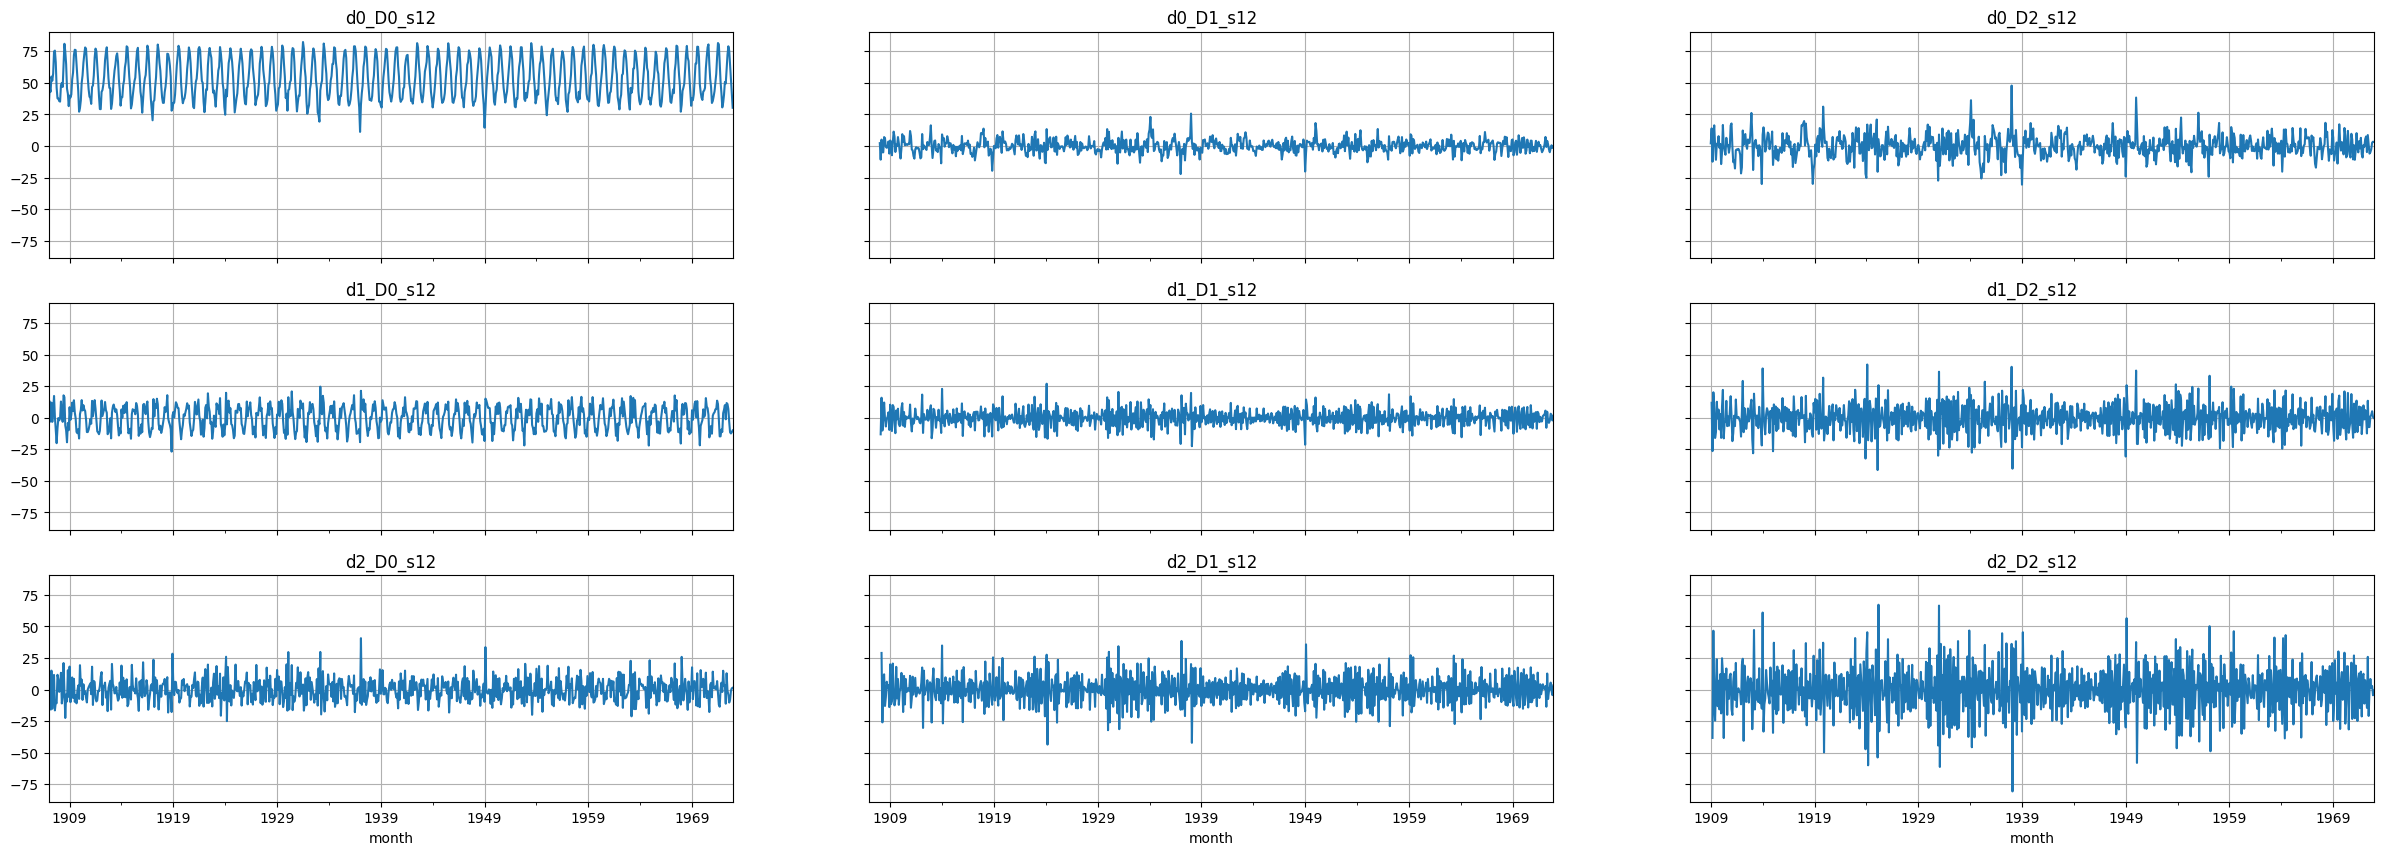

In [55]:
# Plot the final set of time series
# NOTE: these plots are too small. Make a larger plot for each series to see things better!
fig, axes = plt.subplots(3, 3, figsize=(30, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    passed_series.iloc[:,i].plot(ax=ax)
    ax.set_title(passed_series.columns[i])
    ax.grid()

#### Выбор возможных значений для $p, q, P, Q$

- Мы собираемся создать скрипт для определения возможных значений порядков компонент AR и MA, как в общей, так и в сезонной части.
- Мы будем использовать функции ACF и PACF.
- До сих пор мы рассматривали `acf_plot` и `pacf_plot`.
- Теперь нам нужно использовать `acf` и `pacf`.
- Нам нужно понять, как они соотносятся.

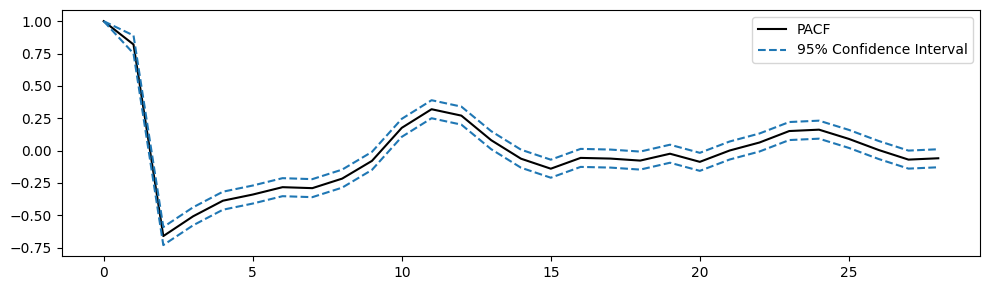

In [56]:
PACF, PACF_ci = pacf(passed_series.iloc[:,0].dropna(), alpha=0.05)

# Plot PACF
plt.figure(figsize=(10,3))
plt.plot(PACF, color='k', label='PACF')
plt.plot(PACF_ci, color='tab:blue', linestyle='--', label=['95% Confidence Interval', ''])
plt.legend()
plt.tight_layout();

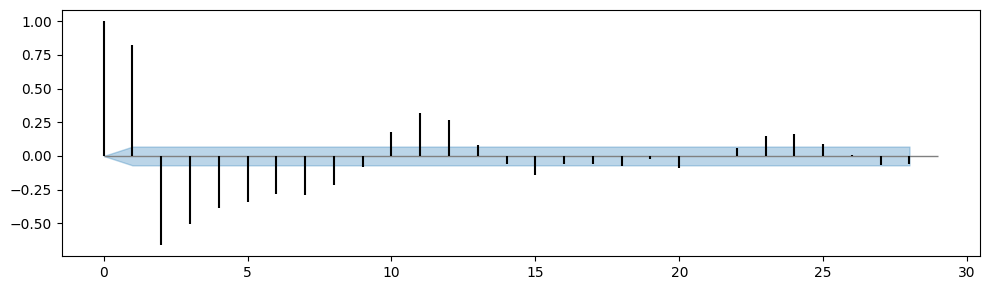

In [57]:
# subtract the confidence interval from the PACF to center the CI in zero
plt.figure(figsize=(10,3))
plt.fill_between(range(29), PACF_ci[:,0] - PACF, PACF_ci[:,1] - PACF, color='tab:blue', alpha=0.3)
plt.hlines(y=0.0, xmin=0, xmax=29, linewidth=1, color='gray')

# Display the PACF as bars
plt.vlines(range(29), [0], PACF[:29], color='black')
plt.tight_layout();

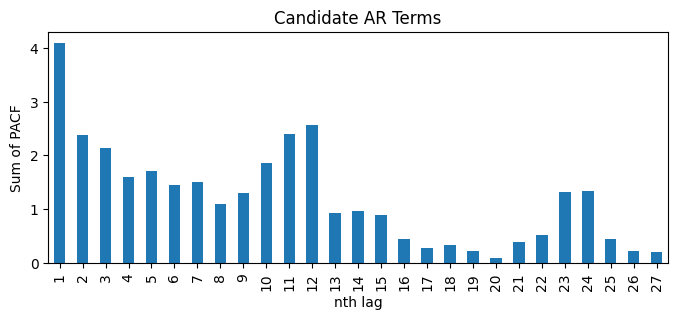

In [58]:
df_sp_p = pd.DataFrame() # create an empty dataframe to store values of significant spikes in PACF plots
for i in passed_series:
    # unpack the results into PACF and their CI
    PACF, PACF_ci = pacf(passed_series[i].dropna(), alpha=0.05, method='ywm')

    # subtract the upper and lower limits of CI by PACF to centre CI at zero
    PACF_ci_ll = PACF_ci[:,0] - PACF
    PACF_ci_ul = PACF_ci[:,1] - PACF

    # find positions of significant spikes representing possible value of p & P
    sp1 = np.where(PACF < PACF_ci_ll)[0]
    sp2 = np.where(PACF > PACF_ci_ul)[0]

    # PACF values of the significant spikes
    sp1_value = abs(PACF[PACF < PACF_ci_ll])
    sp2_value = PACF[PACF > PACF_ci_ul]

    # store values to dataframe
    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)

# Sort the dataframe by index
df_sp_p = df_sp_p.sort_index()

# visualize sums of values of significant spikes in PACF plots ordered by lag
df_sp_p.iloc[1:].T.sum().plot(kind='bar', title='Candidate AR Terms', xlabel='nth lag', ylabel='Sum of PACF', figsize=(8,3));

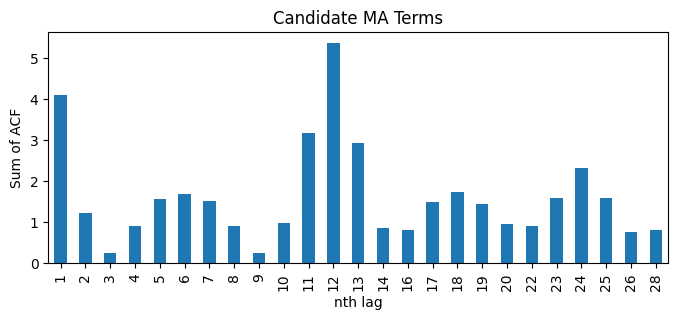

In [59]:
df_sp_q = pd.DataFrame()
for i in passed_series:
    # unpack the results into ACF and their CI
    ACF, ACF_ci = acf(passed_series[i].dropna(), alpha=0.05)

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    ACF_ci_ll = ACF_ci[:,0] - ACF
    ACF_ci_ul = ACF_ci[:,1] - ACF

    # find positions of significant spikes representing possible value of q & Q
    sp1 = np.where(ACF < ACF_ci_ll)[0]
    sp2 = np.where(ACF > ACF_ci_ul)[0]

    # ACF values of the significant spikes
    sp1_value = abs(ACF[ACF < ACF_ci_ll])
    sp2_value = ACF[ACF > ACF_ci_ul]

    # store values to dataframe
    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_q = pd.concat((df_sp_q, sp1_series, sp2_series), axis=1)

# Sort the dataframe by index
df_sp_q = df_sp_q.sort_index()

# visualize sums of values of significant spikes in ACF plots ordered by lags
df_sp_q.iloc[1:].T.sum().plot(kind='bar', title='Candidate MA Terms', xlabel='nth lag', ylabel='Sum of ACF', figsize=(8,3));

#### Определим возможные значения для поиска по сетке

In [60]:
# possible values
p = [1, 2, 3]
d = [0, 1]
q = [1, 2]
P = [0, 1]
D = [0, 1, 2]
Q = [0, 1]
s = [12]

# create all combinations of possible values
pdq = list(product(p, d, q))
PDQm = list(product(P, D, Q, s))

print(f"Number of total combinations: {len(pdq)*len(PDQm)}")

Number of total combinations: 144


#### Обучаем модели
- Мы определили функцию, которая берет каждую конфигурацию модели и обучает модель..
- Для каждой модели мы сохраняем MSE, MAPE, AIC и BIC.

In [61]:
warnings.simplefilter("ignore")
def SARIMA_grid(endog, order, seasonal_order):

    # create an empty list to store values
    model_info = []

    #fit the model
    for i in tqdm(order):
        for j in seasonal_order:
            try:
                model_fit = SARIMAX(endog=endog, order=i, seasonal_order=j).fit(disp=False)
                predict = model_fit.predict()

                # calculate evaluation metrics: MAPE, RMSE, AIC & BIC
                MAPE = (abs((endog-predict)[1:])/(endog[1:])).mean()
                MSE = mse(endog[1:], predict[1:])
                AIC = model_fit.aic
                BIC = model_fit.bic

                # save order, seasonal order & evaluation metrics
                model_info.append([i, j, MAPE, MSE, AIC, BIC])
            except:
                continue

    # create a dataframe to store info of all models
    columns = ["order", "seasonal_order", "MAPE", "MSE", "AIC", "BIC"]
    model_info = pd.DataFrame(data=model_info, columns=columns)
    return model_info

In [62]:
# create train-test-split
train = monthly_temp['temp'].iloc[:int(len(monthly_temp)*0.9)]
test = monthly_temp['temp'].iloc[int(len(monthly_temp)*0.9):]

In [63]:
start = time.time()

# fit all combinations into the model
model_info = SARIMA_grid(endog=train, order=pdq, seasonal_order=PDQm)

end = time.time()
print(f'time required: {end - start :.2f}')

  0%|          | 0/12 [00:00<?, ?it/s]

time required: 233.07


#### Анализ результатов

- Покажем 10 лучших моделей по метрикам (MSE, MAPE) и сложности модели (AIC, BIC)..

In [64]:
# 10 least MAPE models
least_MAPE = model_info.nsmallest(10, "MAPE")
least_MAPE

,order,seasonal_order,MAPE,MSE,AIC,BIC
140,"(3, 1, 2)","(1, 1, 1, 12)",0.069033,16.776945,3860.354011,3896.751217
44,"(1, 1, 2)","(1, 1, 1, 12)",0.069051,16.774439,3855.634110,3882.932015
128,"(3, 1, 1)","(1, 1, 1, 12)",0.069079,16.741148,3856.094854,3887.942410
80,"(2, 1, 1)","(1, 1, 1, 12)",0.069124,16.802794,3857.201555,3884.499459
134,"(3, 1, 2)","(0, 1, 1, 12)",0.069127,16.792908,3859.568077,3891.415632
38,"(1, 1, 2)","(0, 1, 1, 12)",0.069130,16.781089,3854.503494,3877.251747
92,"(2, 1, 2)","(1, 1, 1, 12)",0.069164,16.805006,3860.034150,3891.881705
122,"(3, 1, 1)","(0, 1, 1, 12)",0.069168,16.746349,3854.845163,3882.143067
74,"(2, 1, 1)","(0, 1, 1, 12)",0.069203,16.811207,3856.176100,3878.924354
32,"(1, 1, 1)","(1, 1, 1, 12)",0.069219,16.826998,3856.770688,3879.518942


In [65]:
# 10 least MSE models
least_MSE = model_info.nsmallest(10, "MSE")
least_MSE

,order,seasonal_order,MAPE,MSE,AIC,BIC
128,"(3, 1, 1)","(1, 1, 1, 12)",0.069079,16.741148,3856.094854,3887.942410
122,"(3, 1, 1)","(0, 1, 1, 12)",0.069168,16.746349,3854.845163,3882.143067
44,"(1, 1, 2)","(1, 1, 1, 12)",0.069051,16.774439,3855.634110,3882.932015
140,"(3, 1, 2)","(1, 1, 1, 12)",0.069033,16.776945,3860.354011,3896.751217
38,"(1, 1, 2)","(0, 1, 1, 12)",0.069130,16.781089,3854.503494,3877.251747
134,"(3, 1, 2)","(0, 1, 1, 12)",0.069127,16.792908,3859.568077,3891.415632
80,"(2, 1, 1)","(1, 1, 1, 12)",0.069124,16.802794,3857.201555,3884.499459
92,"(2, 1, 2)","(1, 1, 1, 12)",0.069164,16.805006,3860.034150,3891.881705
74,"(2, 1, 1)","(0, 1, 1, 12)",0.069203,16.811207,3856.176100,3878.924354
86,"(2, 1, 2)","(0, 1, 1, 12)",0.069289,16.825122,3859.565056,3886.862960


In [66]:
# 10 least AIC models
least_AIC = model_info.nsmallest(10, "AIC")
least_AIC

,order,seasonal_order,MAPE,MSE,AIC,BIC
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,61.491561,3846.181890,3864.386212
9,"(1, 0, 1)","(1, 1, 1, 12)",0.080153,61.471329,3846.879649,3869.635051
15,"(1, 0, 2)","(0, 1, 1, 12)",0.080286,61.482998,3847.914835,3870.670236
50,"(2, 0, 1)","(0, 1, 1, 12)",0.080283,61.485309,3847.985625,3870.741026
98,"(3, 0, 1)","(0, 1, 1, 12)",0.080295,61.449767,3848.292676,3875.599158
20,"(1, 0, 2)","(1, 1, 1, 12)",0.080146,61.461761,3848.568559,3875.875041
56,"(2, 0, 1)","(1, 1, 1, 12)",0.080145,61.464316,3848.650344,3875.956826
116,"(3, 0, 2)","(1, 1, 1, 12)",0.080079,61.399672,3849.047903,3885.456546
104,"(3, 0, 1)","(1, 1, 1, 12)",0.080096,61.430629,3849.069448,3880.927010
62,"(2, 0, 2)","(0, 1, 1, 12)",0.080282,61.469826,3849.361800,3876.668282


In [67]:
# 10 least BIC models
least_BIC = model_info.nsmallest(10, "BIC")
least_BIC

,order,seasonal_order,MAPE,MSE,AIC,BIC
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,61.491561,3846.181890,3864.386212
9,"(1, 0, 1)","(1, 1, 1, 12)",0.080153,61.471329,3846.879649,3869.635051
15,"(1, 0, 2)","(0, 1, 1, 12)",0.080286,61.482998,3847.914835,3870.670236
50,"(2, 0, 1)","(0, 1, 1, 12)",0.080283,61.485309,3847.985625,3870.741026
26,"(1, 1, 1)","(0, 1, 1, 12)",0.069317,16.836791,3855.817167,3874.015770
98,"(3, 0, 1)","(0, 1, 1, 12)",0.080295,61.449767,3848.292676,3875.599158
20,"(1, 0, 2)","(1, 1, 1, 12)",0.080146,61.461761,3848.568559,3875.875041
56,"(2, 0, 1)","(1, 1, 1, 12)",0.080145,61.464316,3848.650344,3875.956826
62,"(2, 0, 2)","(0, 1, 1, 12)",0.080282,61.469826,3849.361800,3876.668282
38,"(1, 1, 2)","(0, 1, 1, 12)",0.069130,16.781089,3854.503494,3877.251747


- Мы можем проверить, есть ли совпадения между четырьмя различными группами, используя `set`.

In [68]:
set(least_MAPE.index) & set(least_MSE.index)

{38, 44, 74, 80, 92, 122, 128, 134, 140}

In [69]:
set(least_AIC.index) & set(least_BIC.index)

{3, 9, 15, 20, 50, 56, 62, 98}

In [70]:
set(least_MSE.index) & set(least_AIC.index)

set()

- Покажем лучшую модель по каждому показателю.

In [71]:
# the best model by each metric
L1 = model_info[model_info.MAPE == model_info.MAPE.min()]
L2 = model_info[model_info.MSE == model_info.MSE.min()]
L3 = model_info[model_info.AIC == model_info.AIC.min()]
L4 = model_info[model_info.BIC == model_info.BIC.min()]

best_models = pd.concat((L1, L2, L3, L4))
best_models

,order,seasonal_order,MAPE,MSE,AIC,BIC
140,"(3, 1, 2)","(1, 1, 1, 12)",0.069033,16.776945,3860.354011,3896.751217
128,"(3, 1, 1)","(1, 1, 1, 12)",0.069079,16.741148,3856.094854,3887.942410
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,61.491561,3846.181890,3864.386212
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,61.491561,3846.181890,3864.386212


#### Вычисление производительности на тестовом наборе данных

- Возьмите лучшие модели, вычислите прогнозы и оцените их производительность в терминах MAPE по отношению к тестовым данным.

In [72]:
# Take the configurations of the best models
ord_list = [tuple(best_models.iloc[i,0]) for i in range(best_models.shape[0])]
s_ord_list = [tuple(best_models.iloc[i,1]) for i in range(best_models.shape[0])]
preds, ci_low, ci_up, MAPE_test = [], [], [], []

# Fit the models and compute the forecasts
for i in range(4):
    model_fit = SARIMAX(endog=train, order=ord_list[i],
                        seasonal_order=s_ord_list[i]).fit(disp=False) # Fit the model
    pred_summary = model_fit.get_prediction(test.index[0],
                                            test.index[-1]).summary_frame() # Compute preds
    # Store results
    preds.append(pred_summary['mean'])
    ci_low.append(pred_summary['mean_ci_lower'][test.index])
    ci_up.append(pred_summary['mean_ci_upper'][test.index])
    MAPE_test.append((abs((test-pred_summary['mean'])/(test)).mean()))

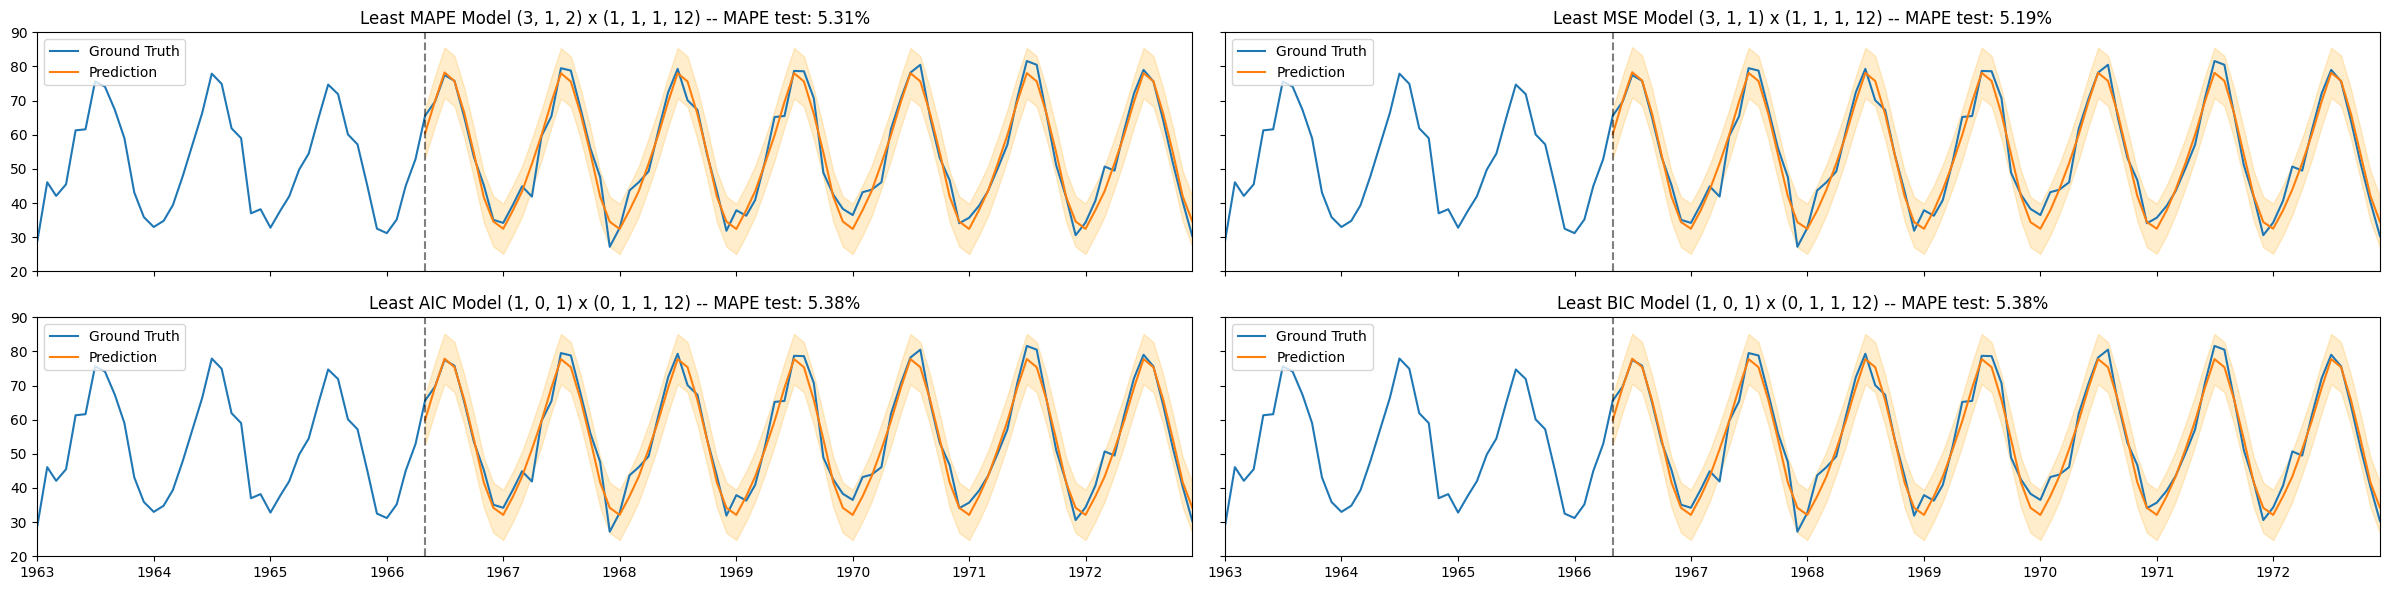

In [73]:
# visualize the results of the fitted models
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24,6),
                        sharex=True, sharey=True)

titles = [f'Least MAPE Model {ord_list[0]} x {s_ord_list[0]}',
          f'Least MSE Model {ord_list[1]} x {s_ord_list[1]}',
          f'Least AIC Model {ord_list[2]} x {s_ord_list[2]}',
          f'Least BIC Model {ord_list[3]} x {s_ord_list[3]}']
k = 0
for i in range(2):
    for j in range(2):
        axs[i,j].plot(monthly_temp['temp'], label='Ground Truth')
        axs[i,j].plot(preds[k], label='Prediction')
        axs[i,j].set_title(titles[k] + f' -- MAPE test: {MAPE_test[k]:.2%}')
        axs[i,j].legend()
        axs[i,j].axvline(test.index[0], color='black', alpha=0.5, linestyle='--')
        axs[i,j].fill_between(x=test.index, y1=ci_low[k], y2=ci_up[k], color='orange', alpha=0.2)
        axs[i,j].set_ylim(bottom=20, top=90)
        axs[i,j].set_xlim(left=monthly_temp.index[-120], right=monthly_temp.index[-1])
        k += 1
plt.tight_layout()
plt.show()

---

## Мы рассмотрели:

1. Авторегрессионную модель скользящего среднего (ARMA).
2. Авторегрессионную интегрированную модель скользящего среднего (ARIMA).
3. SARIMA-модель (ARIMA-модель для данных с сезонностью).
4. Выбор наилучшей модели.

---

## Упражнение

- Посмотрите на данные датчика, который отслеживает атмосферный CO2 из непрерывных проб воздуха в обсерватории Мауна-Лоа на Гавайях. Эти данные включают пробы CO2 с марта 1958 года по декабрь 1980 года.

In [74]:
co2 = pd.read_csv('https://zenodo.org/records/10951538/files/arima_co2.csv?download=1',
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)

# convert the column idx into a datetime object and set it as the index
co2['idx'] = pd.to_datetime(co2['idx'])
co2.set_index('idx', inplace=True)

# Rmove the name "idx" from the index column
co2.index.name = None
co2

,co2
1965-01-01,319.32
1965-02-01,320.36
1965-03-01,320.82
1965-04-01,322.06
1965-05-01,322.17
...,...
1980-08-01,337.19
1980-09-01,335.49
1980-10-01,336.63
1980-11-01,337.74


In [75]:
def seas_decomp_plots(original, decomposition):
    _, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(7, 5))
    axes[0].plot(original, label='Original')
    axes[0].legend(loc='upper left')
    axes[1].plot(decomposition.trend, label='Trend')
    axes[1].legend(loc='upper left')
    axes[2].plot(decomposition.seasonal, label='Seasonality')
    axes[2].legend(loc='upper left')
    axes[3].plot(decomposition.resid, label='Residuals')
    axes[3].legend(loc='upper left')
    plt.show()

- Определите наличие основного тренда и сезонности в данных..


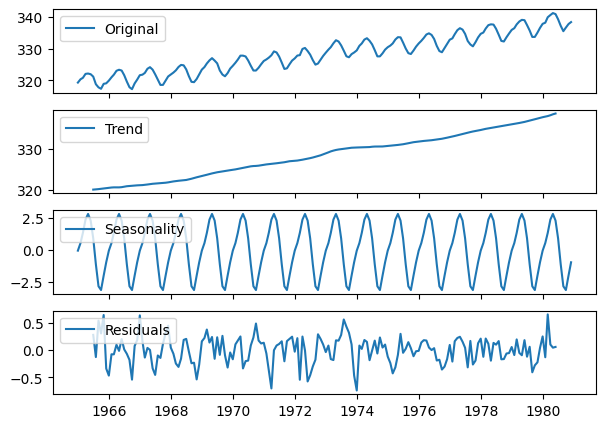

In [76]:
decomposition = seasonal_decompose(x=co2, model='additive', period=12)
seas_decomp_plots(co2, decomposition)

Есть и тренд, и сезонность

- Определите, являются ли данные стационарными.

ADF Statistic: 1.27
p-value: 0.996
Critical Values: ['1%: -3.47', '5%: -2.88', '10%: -2.58']



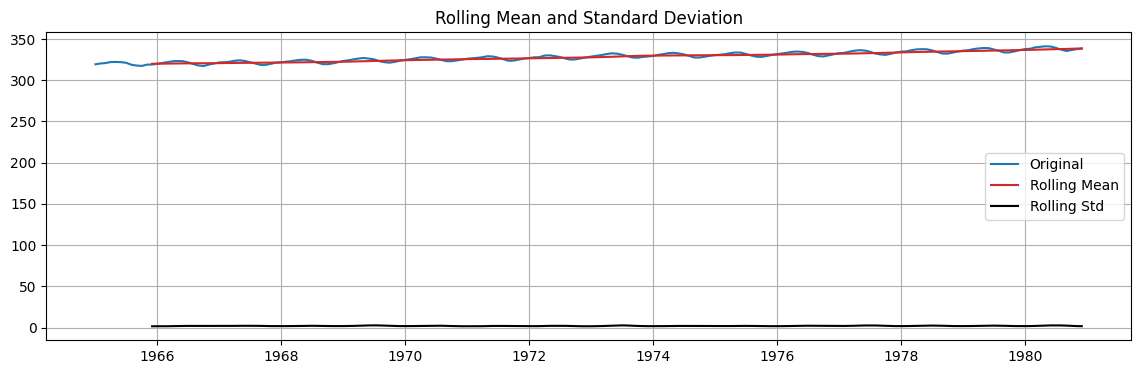

In [77]:
adftest(co2)

Ряд, очевидно, не является стационарным


- Разделите данные на обучающую (90%) и тестовую (10%) выборки.

In [78]:
train, test = co2[:int(0.9*len(co2))], co2[int(0.9*len(co2)):]
print(len(train), len(test))

172 20


- Найдите набор моделей-кандидатов SARIMAX, посмотрев на ACF и PACF..


In [79]:
period, _, _ =fft_analysis(train.squeeze())
print(f"Period: {np.round(period)}")

Dominant Frequency: 0.081
Dominant Period: 12.29 time units
Period: 12.0


s = 12

ADF Statistic: -2.94
p-value: 0.041
Critical Values: ['1%: -3.48', '5%: -2.88', '10%: -2.58']

ADF Statistic: -3.43
p-value: 0.010
Critical Values: ['1%: -3.48', '5%: -2.88', '10%: -2.58']



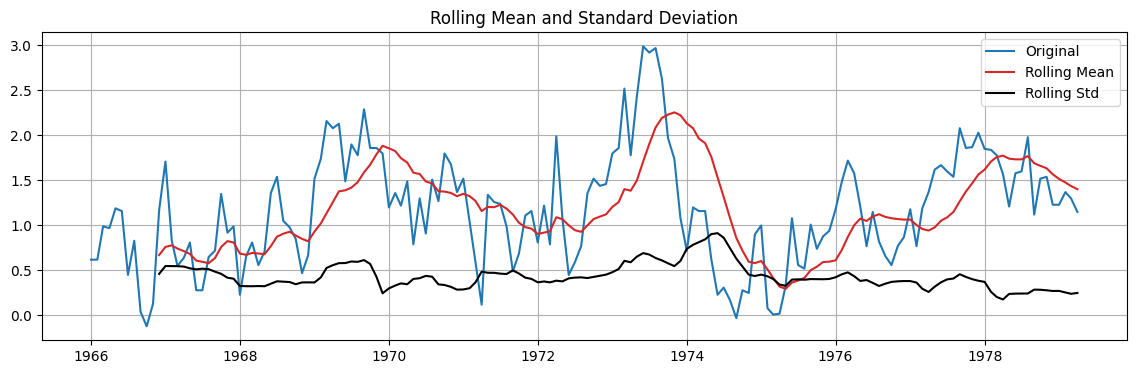

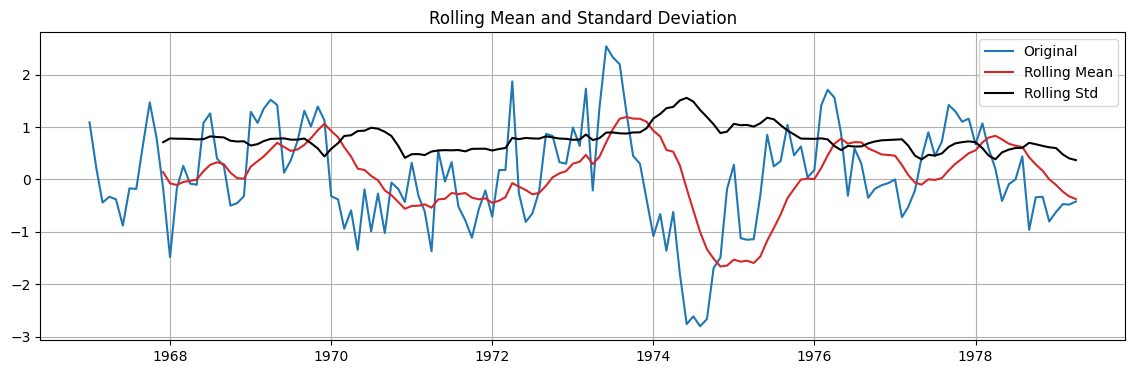

In [80]:
train_diff = train.diff(periods=12).dropna()
train_seasonal_diff = train_diff.diff(12).dropna()  
adftest(train_diff)
adftest(train_seasonal_diff)

d = 1  
D = 1

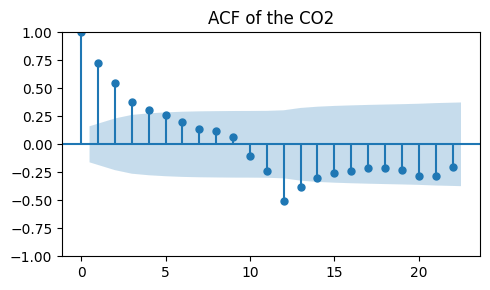

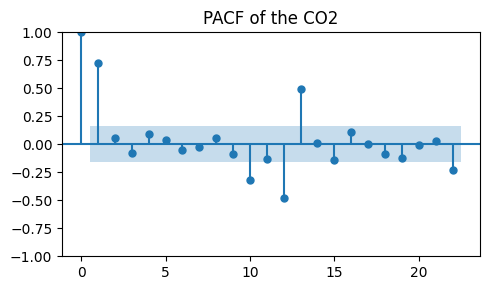

In [81]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(train_seasonal_diff, ax=ax, title="ACF of the CO2")
plt.tight_layout();
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(train_seasonal_diff, ax=ax, title="PACF of the CO2")
plt.tight_layout();

p = 1  
d = 1  
q = 1  
  
s = 12  
P = 1  
D = 1  
Q = 1  


- Выполните поиск по сетке для моделей-кандидатов..


In [82]:
# possible values
p = [0, 1, 2, 3, 4]
d = [0, 1, 2, 3, 4]
q = [0, 1, 2, 3, 4]
P = [0, 1, 2]
D = [0, 1, 2]
Q = [0, 1, 2]
s = [12]

# create all combinations of possible values
pdq = list(product(p, d, q))
PDQm = list(product(P, D, Q, s))

print(f"Number of total combinations: {len(pdq)*len(PDQm)}")

start = time.time()

# fit all combinations into the model
model_info = SARIMA_grid(endog=train.squeeze(), order=pdq, seasonal_order=PDQm)

end = time.time()
print(f'time required: {end - start :.2f}')

Number of total combinations: 3375


  0%|          | 0/125 [00:00<?, ?it/s]

time required: 5164.81


- Выберите лучшие модели на основе метрик качества предсказаний, сложности модели и нормальности остатков.

In [83]:
# 10 least MAPE models
least_MAPE = model_info.nsmallest(10, "MAPE")
least_MAPE

,order,seasonal_order,MAPE,MSE,AIC,BIC
2927,"(4, 1, 4)","(2, 0, 1, 12)",0.000861,0.139215,139.104665,176.804628
2263,"(3, 1, 4)","(2, 0, 2, 12)",0.000865,0.148483,137.945406,175.645369
2253,"(3, 1, 4)","(1, 0, 1, 12)",0.000870,0.143796,136.108335,167.524970
2892,"(4, 1, 3)","(1, 0, 1, 12)",0.000870,0.142128,135.435064,166.851700
1594,"(2, 1, 4)","(1, 0, 2, 12)",0.000872,0.143467,136.716202,168.132837
2893,"(4, 1, 3)","(1, 0, 2, 12)",0.000873,0.142059,137.842489,172.400788
2918,"(4, 1, 4)","(1, 0, 1, 12)",0.000873,0.144200,140.575740,175.134039
2254,"(3, 1, 4)","(1, 0, 2, 12)",0.000875,0.144402,139.178784,173.737083
2928,"(4, 1, 4)","(2, 0, 2, 12)",0.000876,0.148128,147.654203,188.495829
1602,"(2, 1, 4)","(2, 0, 1, 12)",0.000877,0.146219,136.653314,168.069949


In [84]:
# 10 least MSE models
least_MSE = model_info.nsmallest(10, "MSE")
least_MSE

,order,seasonal_order,MAPE,MSE,AIC,BIC
2927,"(4, 1, 4)","(2, 0, 1, 12)",0.000861,0.139215,139.104665,176.804628
2893,"(4, 1, 3)","(1, 0, 2, 12)",0.000873,0.142059,137.842489,172.400788
2892,"(4, 1, 3)","(1, 0, 1, 12)",0.000870,0.142128,135.435064,166.851700
1594,"(2, 1, 4)","(1, 0, 2, 12)",0.000872,0.143467,136.716202,168.132837
2253,"(3, 1, 4)","(1, 0, 1, 12)",0.000870,0.143796,136.108335,167.524970
2918,"(4, 1, 4)","(1, 0, 1, 12)",0.000873,0.144200,140.575740,175.134039
2254,"(3, 1, 4)","(1, 0, 2, 12)",0.000875,0.144402,139.178784,173.737083
2919,"(4, 1, 4)","(1, 0, 2, 12)",0.000877,0.146071,143.388568,181.088531
1602,"(2, 1, 4)","(2, 0, 1, 12)",0.000877,0.146219,136.653314,168.069949
2928,"(4, 1, 4)","(2, 0, 2, 12)",0.000876,0.148128,147.654203,188.495829


In [85]:
# 10 least AIC models
least_AIC = model_info.nsmallest(10, "AIC")
least_AIC

,order,seasonal_order,MAPE,MSE,AIC,BIC
99,"(0, 0, 3)","(2, 0, 1, 12)",1.000000e+00,1.072458e+05,14.000000,36.032461
125,"(0, 0, 4)","(2, 0, 0, 12)",1.000000e+00,1.072458e+05,14.000000,36.032461
375,"(0, 2, 3)","(2, 2, 2, 12)",2.912993e+00,2.305921e+06,16.000000,39.868853
1305,"(1, 4, 3)","(1, 2, 2, 12)",1.195478e+05,6.150054e+15,16.000000,39.758506
2624,"(3, 4, 3)","(1, 0, 0, 12)",1.494373e+06,6.883339e+17,16.000000,40.991712
2493,"(3, 3, 3)","(1, 0, 1, 12)",6.803582e+05,1.211465e+17,18.000000,46.169088
3250,"(4, 4, 1)","(2, 0, 2, 12)",1.000000e+00,1.072458e+05,20.000000,51.239640
1165,"(1, 3, 3)","(1, 0, 2, 12)",3.213365e+02,2.701236e+10,65.646599,90.685789
1297,"(1, 4, 3)","(1, 0, 0, 12)",6.379262e+02,1.327114e+11,77.914050,96.657834
165,"(0, 1, 1)","(0, 1, 1, 12)",3.811937e-03,1.476624e+02,90.472628,99.679340


In [86]:
# 10 least BIC models
least_BIC = model_info.nsmallest(10, "BIC")
least_BIC

,order,seasonal_order,MAPE,MSE,AIC,BIC
99,"(0, 0, 3)","(2, 0, 1, 12)",1.000000e+00,1.072458e+05,14.000000,36.032461
125,"(0, 0, 4)","(2, 0, 0, 12)",1.000000e+00,1.072458e+05,14.000000,36.032461
1305,"(1, 4, 3)","(1, 2, 2, 12)",1.195478e+05,6.150054e+15,16.000000,39.758506
375,"(0, 2, 3)","(2, 2, 2, 12)",2.912993e+00,2.305921e+06,16.000000,39.868853
2624,"(3, 4, 3)","(1, 0, 0, 12)",1.494373e+06,6.883339e+17,16.000000,40.991712
2493,"(3, 3, 3)","(1, 0, 1, 12)",6.803582e+05,1.211465e+17,18.000000,46.169088
3250,"(4, 4, 1)","(2, 0, 2, 12)",1.000000e+00,1.072458e+05,20.000000,51.239640
1165,"(1, 3, 3)","(1, 0, 2, 12)",3.213365e+02,2.701236e+10,65.646599,90.685789
1297,"(1, 4, 3)","(1, 0, 0, 12)",6.379262e+02,1.327114e+11,77.914050,96.657834
165,"(0, 1, 1)","(0, 1, 1, 12)",3.811937e-03,1.476624e+02,90.472628,99.679340


Допустим, что модель 2927	(4, 1, 4)	(2, 0, 1, 12)	0.000861	0.139215	139.104665	176.804628	достаточно хороша

In [91]:
model_info.loc[2927]

order                 (4, 1, 4)
seasonal_order    (2, 0, 1, 12)
MAPE                   0.000861
MSE                    0.139215
AIC                  139.104665
BIC                  176.804628
Name: 2927, dtype: object


- Сравните лучшую найденную вами модель с моделью из autoarima.

In [88]:
model_pmd  = pm.auto_arima(train.squeeze(),
                      start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=4, max_q=4, # Maximum p and q
                      m=12,             # Seasonality
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2, # Maximum p and q
                      seasonal=True,    # Seasonal ARIMA
                      d=None,           # Let model determine 'd'
                      D=1,              # Seasonal difference
                      trace=True,       # Print status on the fits
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)    # Stepwise search to find the best model
n_periods = len(test)
forecast_pmd, conf_int = model_pmd.predict(
    n_periods=n_periods,
    return_conf_int=True  
)
# MAPE (учитываем только ненулевые значения)
non_zero_mask = test.squeeze() != 0
mape_value = mape(test.squeeze()[non_zero_mask], forecast_pmd[non_zero_mask]) * 100  # В процентах

# MSE
mse_value = mse(test.squeeze(), forecast_pmd)

# AIC и BIC (рассчитываются на тренировочных данных)
aic_value = model_pmd.aic()
bic_value = model_pmd.bic()

print(f"MAPE: {mape_value:.2f}%")
print(f"MSE: {mse_value:.2f}")
print(f"AIC: {aic_value:.2f}")
print(f"BIC: {bic_value:.2f}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=170.140, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=116.893, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=167.257, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=112.261, Time=0.19 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=116.848, Time=0.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=114.093, Time=0.33 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=111.836, Time=0.30 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=116.214, Time=0.14 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=111.627, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=116.499, T

In [92]:
# Обучение модели
model_sarimax = SARIMAX(
    endog=train.squeeze(), 
    order=(4, 1, 4), #(1, 1, 1), 
    seasonal_order= (2, 0, 1, 12) # (1, 0, 1, 12)
).fit(disp=False)  
	
# Прогноз на длину тестовых данных
n_periods = len(test)
forecast_sarimax  = model_sarimax.get_forecast(steps=n_periods)

# Создание индекса прогноза (пример для месячных данных)
forecast_index = pd.date_range(
    start=train.index[-1] + pd.DateOffset(months=1),  # Следующий месяц после последней даты в train
    periods=n_periods,
    freq='MS'  # Частота (например, 'MS' для начала месяца)
)

# Прогнозные значения с правильным индексом
forecast_sarimax_series  = pd.Series(forecast_sarimax .predicted_mean, index=forecast_index)
conf_int_sarimax = forecast_sarimax.conf_int()

# Синхронизация тестовых данных с прогнозом
test_aligned = test.squeeze().reindex(forecast_index)

# Расчет метрик
non_zero_mask = test_aligned != 0  # Маска для ненулевых значений

# MAPE
if non_zero_mask.any():
    mape_value = (abs((test_aligned[non_zero_mask] - forecast_sarimax_series [non_zero_mask]) / test_aligned[non_zero_mask]).mean() * 100)
else:
    mape_value = np.nan  # Если все нули

# MSE
mse_value = mse(test_aligned, forecast_sarimax_series )

# AIC и BIC
aic_value = model_sarimax.aic
bic_value = model_sarimax.bic

print(f"MAPE: {mape_value:.2f}%")
print(f"MSE: {mse_value:.2f}")
print(f"AIC: {aic_value:.2f}")
print(f"BIC: {bic_value:.2f}")

MAPE: 0.21%
MSE: 0.77
AIC: 139.10
BIC: 176.80


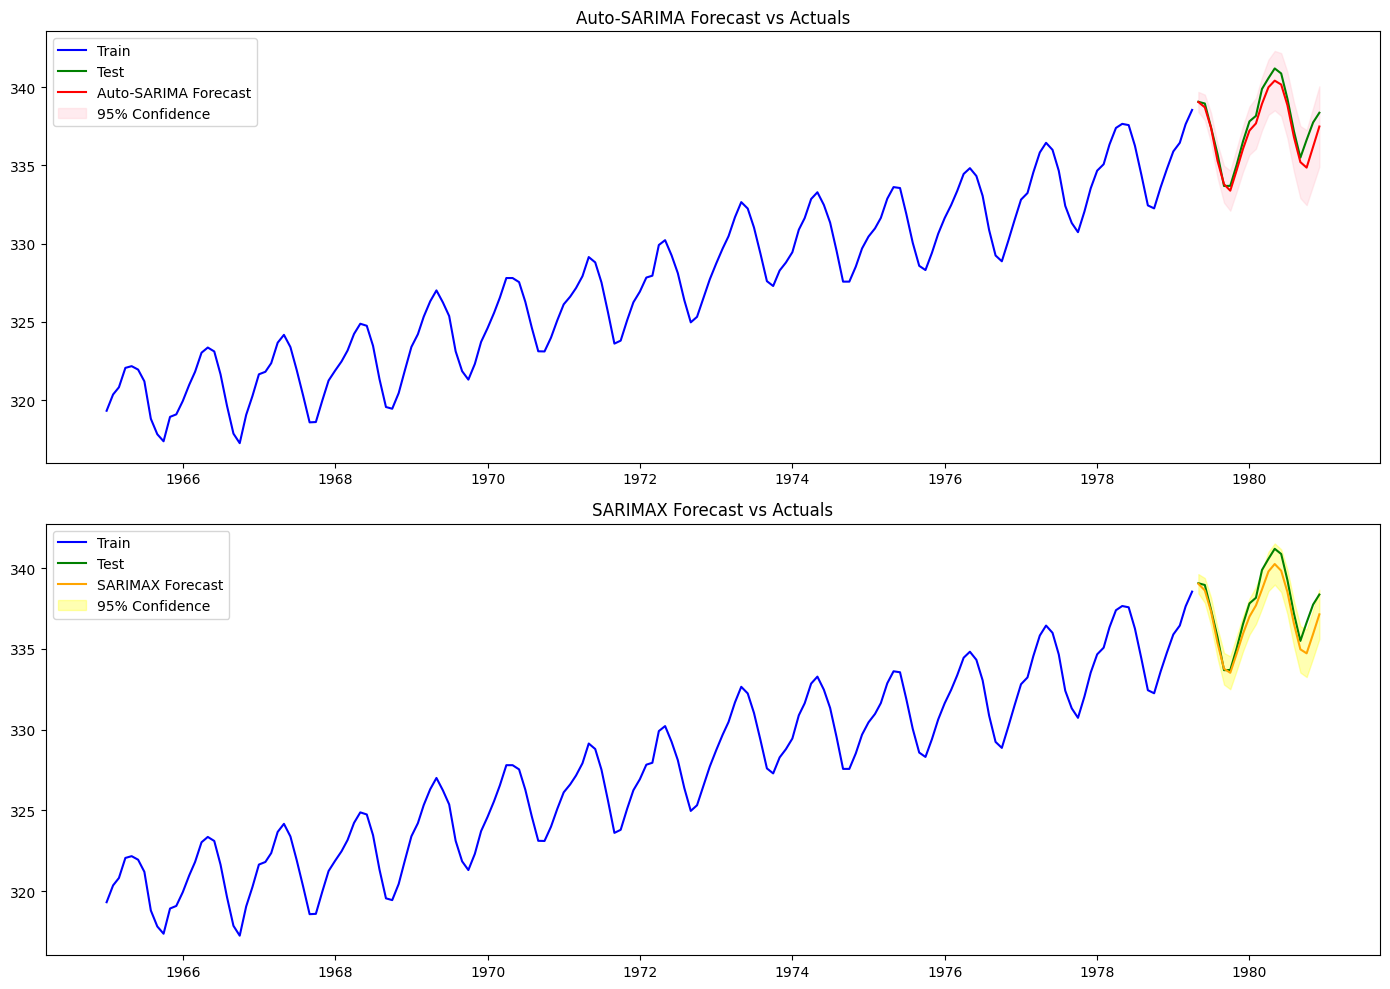

In [93]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# График 1: Модель pmdarima
axes[0].plot(train, label='Train', color='blue')
axes[0].plot(test, label='Test', color='green')
axes[0].plot(forecast_index, forecast_pmd, label='Auto-SARIMA Forecast', color='red')
axes[0].fill_between(
    forecast_index,
    conf_int[:, 0],
    conf_int[:, 1],
    color='pink',
    alpha=0.3,
    label='95% Confidence'
)
axes[0].set_title('Auto-SARIMA Forecast vs Actuals')
axes[0].legend()

# График 2: Модель SARIMAX
axes[1].plot(train, label='Train', color='blue')
axes[1].plot(test, label='Test', color='green')
axes[1].plot(forecast_sarimax_series.index, forecast_sarimax_series, 
            label='SARIMAX Forecast', color='orange')
axes[1].fill_between(
    forecast_sarimax_series.index,
    conf_int_sarimax.iloc[:, 0],
    conf_int_sarimax.iloc[:, 1],
    color='yellow',
    alpha=0.3,
    label='95% Confidence'
)
axes[1].set_title('SARIMAX Forecast vs Actuals')
axes[1].legend()

plt.tight_layout()
plt.show()

В сравнении выигрывает model_pmd, то есть auto_arima